**Normalizing Flows**
---

Normalizing Flows (NFs) são modelos generativos usados para modelar distribuições de probabilidade arbitrárias, permitindo amostragem e avaliação de densidade de maneira eficiente e acurada. A ideia principal dos NFs é encontrar transformações que mapeam uma distribuição de probabilidade simples (como uma gaussiana, por exemplo) em uma distribuição alvo mais complexa. As transformações usadas devem ser bijetoras (ou seja, cada ponto em uma distribuição corresponde a apenas um único onto na outra distribuição), e consequentemente, inversíveis, o que garante que esse mapeamento funcione nas duas direções, e os parâmetros destas tranformações são determinados por redes neurais, o que permite o processo de treinamento dos Flows.

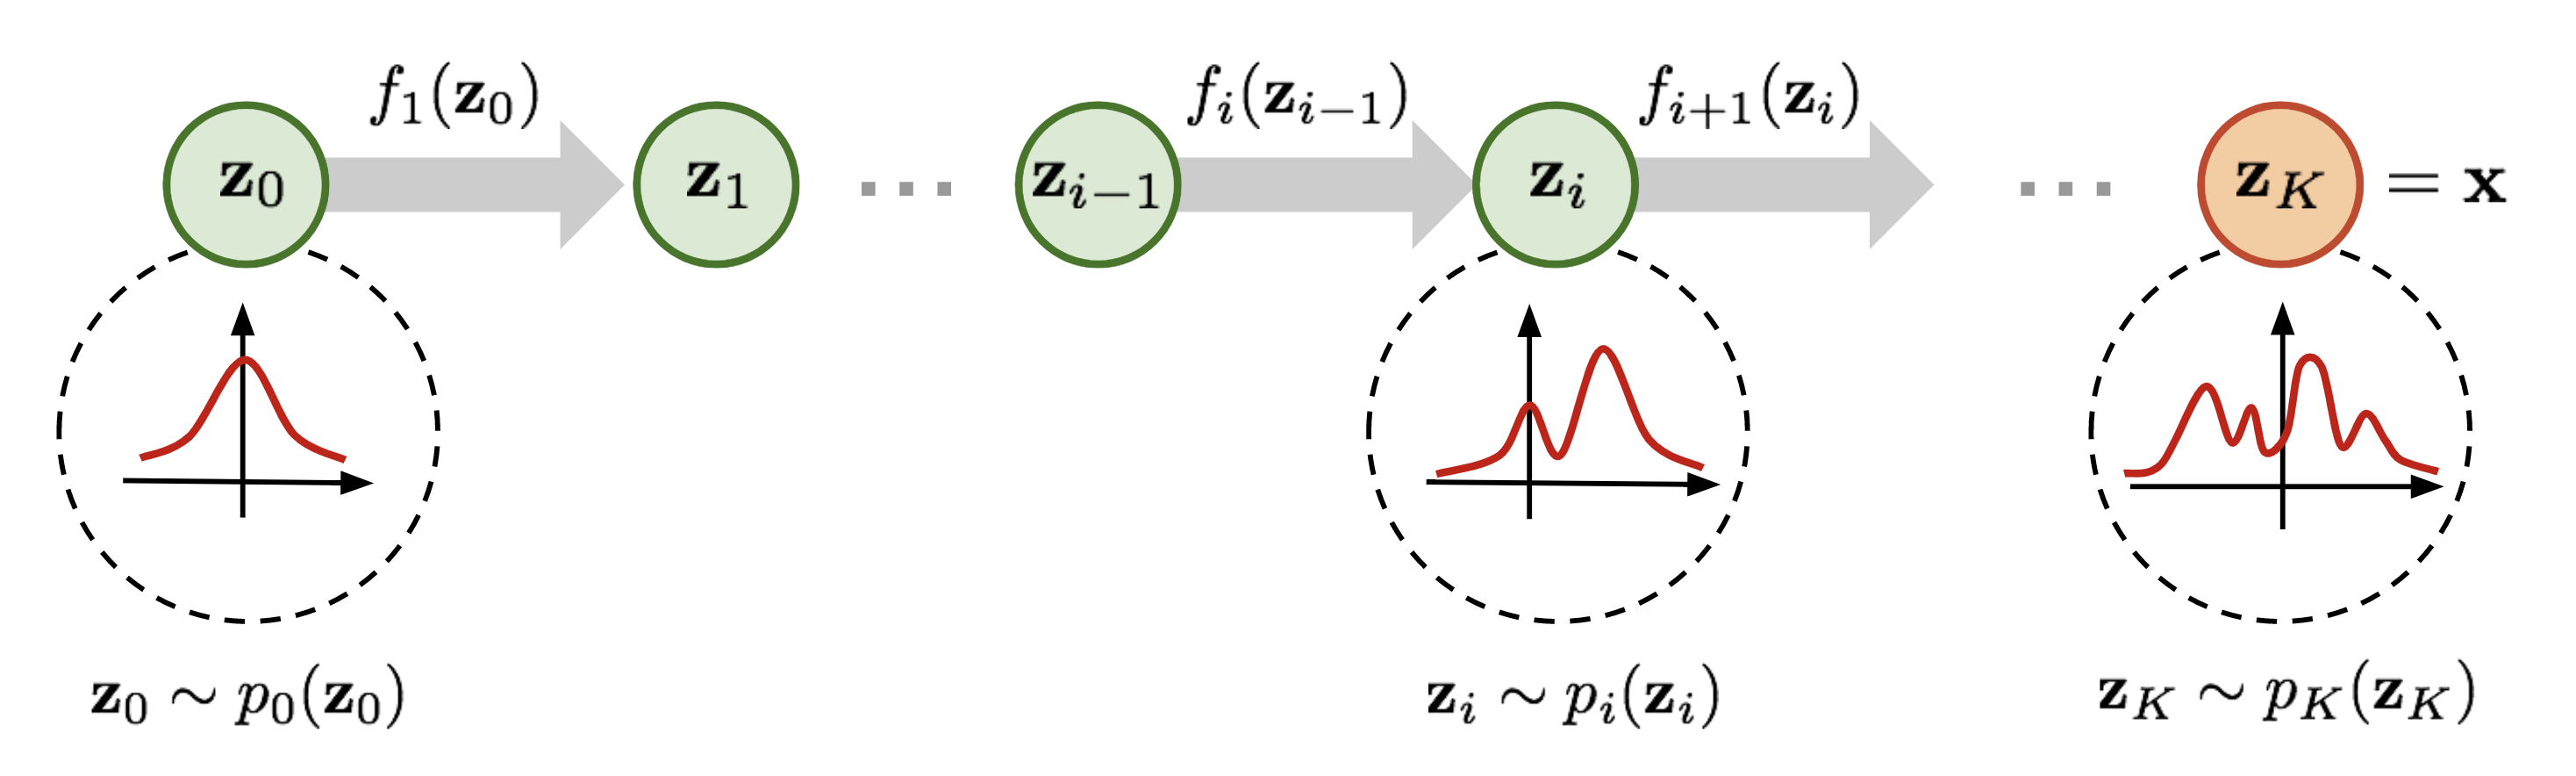

Sendo $z$ uma amostra de uma distribuição simples qualquer, temos:

\begin{equation}
z \sim p(z)
\end{equation}

Nossa variável em uma distribuição complexa é:

\begin{equation}
x = F(z) = f_n \circ f_{n-1} \circ ... \circ f_{1}(z)
\end{equation}

onde cada função $f$ é uma das tranformações do Flow. Usando a fórmula de mudança de variáveis, podemos escrever:

\begin{equation}
p(x) = p(F^{-1}(x))\left| \det \frac{∂F^{-1}(x)}{\partial x} \right|
\end{equation}

Onde $\frac{∂F^{-1}(x)}{\partial x}$ é a chamada matriz jacobiana da transformação. De maneira simplificada, podemos escrever:

\begin{equation}
p(x) = p(z) \left| \det J_{z,x} \right|
\end{equation}

Assim, para transformar de uma distribuição para a outra, basta calcular o determinante da matriz jacobiana da transformação. Boas escolhas de transformações levam em consideração a expressividade da transformação, ou seja, sua capacidade de alterar a distribuição original além da facilidade do cálculo do determinante.

Um exemplo de bijetor é a transformação linear, dada por:

\begin{equation}
h(x;\Theta) = \theta_1 x + \theta_2
\end{equation}

Esta transformação é fácil de calcular, mas não oferece muita expressividade, isto é, a distribuição base não é suficientemente alterada usando esta transformação. A transformação linear pode servir como base para transformações mais complexas, como veremos mais a frente.

Masked Autoregressive Flow (MAF)
---
Uma maneira de garantir um determinante fácil de calcular é usando a propriedade da autoregressividade. Se temos uma bijeção $h(z, \theta)$, e um modelo que mapeia $\textbf{x} = \{x_1, ..., x_i, ..., x_D\}$ em $\textbf{y} = \{y_1,...,y_D\}$ de modo $y=g(x)$, $g$ é dito autoregressivo se:

\begin{equation}
    y_t = h(x_t;\Theta_t(x_{1:t-1}))
\end{equation}

Isto é, se a transformação da t-ésima dimensão de x é uma bijeção cujos parâmetros dependem das $t-1$ dimensões anteriores de x ($\{x_1, ..., x_{t-1}\}$), mas não das dimensões seguintes ($\{x_{t+1}, ..., x_D\}$). Esta propriedade garante que a matriz jacobiana da transformação seja triangular inferior, e assim, seu determinante é dado pelo produto dos elementos da diagonal principal. Os parâmetros $\Theta_{x_1:x{t-1}}$
 da transformação são o produto de uma rede neural que toma como entrada o conjunto ${x_1, ..., x_{t-1}}$. Em termos práticos, essa propriedade é alcançada introduzindo uma matriz binária chamada de máscara, que zera as conexões necessárias para a autoregressividade. Os [MAFs](https://arxiv.org/abs/1705.07057) usam transformações lineares nas quais os parâmetros $\Theta$ são produtos de redes neurais obecendo a regra da autoregressividade. Esta transformação tem bom desempenho em tarefas de density estimation, mas sofre em performance em geração de dados.

Uma aplicação prática deste Flow pode ser feita usando o módulo [nflows](https://pypi.org/project/nflows/). O código a seguir é adaptdado [deste tutorial](https://github.com/bayesiains/nflows/blob/569c8ad50941824ccb07aa3a3eb59c85721e0c5f/examples/moons.ipynb).

In [1]:
!pip install nflows --quiet

import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from IPython import display
from tqdm import tqdm

Começamos criando um dataset de pontos retirados de uma distribuição de probabilidade arbitrária. Para isso, usamos a função make_moons do módulo sci-kit learn.

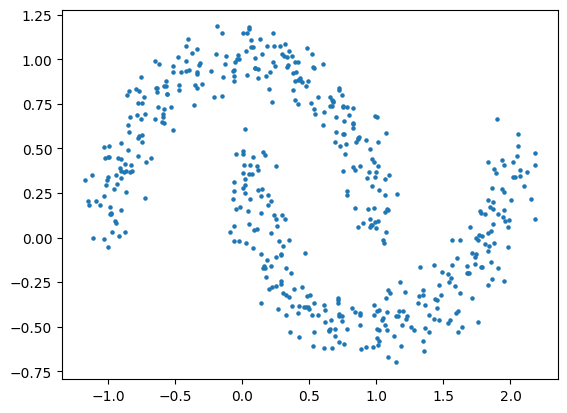

In [2]:
x, y = datasets.make_moons(512, noise=.1)
plt.scatter(x[:, 0], x[:, 1], s=5);

E  uma distribuição base. Usaremos a distribuição gaussiana com média 0 e desvio padrão 1.

In [3]:
base_dist = StandardNormal(shape=[2])

Definimos então como será o flow. Neste caso, usaremos um MAF cujo bijetor será uma transformação affine. Esta transformação é seguida de uma permutação de dimensões, para evitar viés devido à ordem original das dimensões. Nosso flow será composto de 5 camadas com estas duas transformações.

In [4]:
num_layers = 5
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, hidden_features=4)) # hidden_features é o a quantidade de unidades escondidas na rede neural
transform = CompositeTransform(transforms)

Por fim, compilamos nossa arquitetura e escolhemos um otimizador

In [5]:
flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

Podemos começar o processo de treinamento

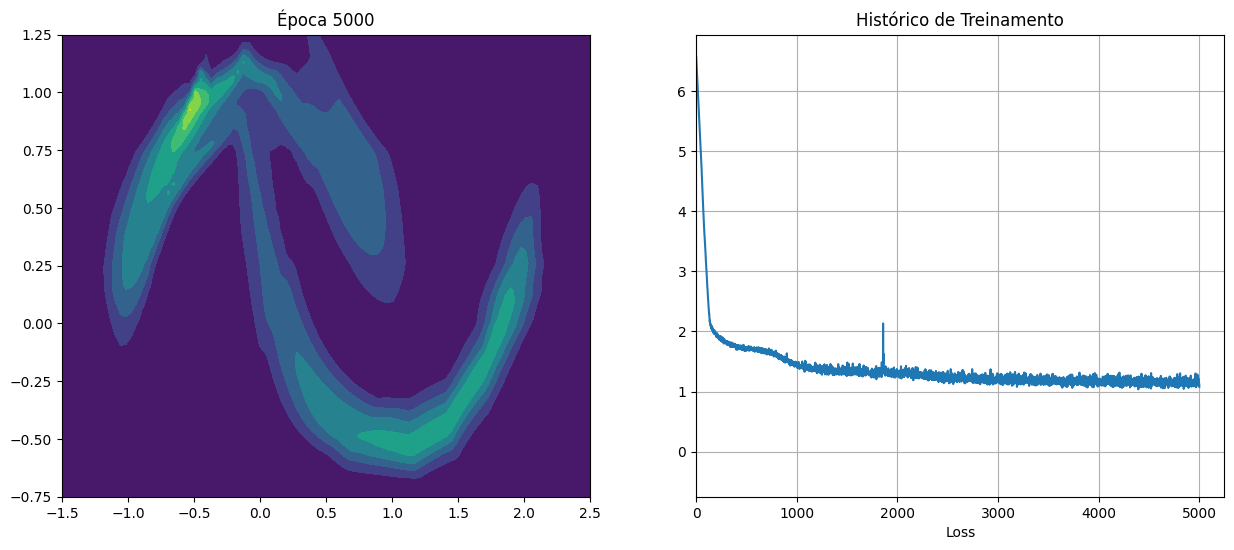

100%|██████████| 5000/5000 [01:38<00:00, 50.58it/s]


In [6]:
num_epochs = 5000
loss_history = []
maf_density_plots = []

for i in tqdm(range(num_epochs)):
    x, y = datasets.make_moons(256, noise=.1, random_state=i) # geramos os dados
    x = torch.tensor(x, dtype=torch.float32) # transformamos em tensor do torch
    optimizer.zero_grad() # zeramos os gradientes do otimizador
    loss = -flow.log_prob(inputs=x).mean() # definimos a função loss como o inverso do log_prob médio calculado sobre a distribuição
    loss_history.append(loss.detach().numpy())
    loss.backward() # calcula os gradientes
    optimizer.step() # atualiza os pesos

    if (i+1) % 500 == 0: # a cada 500 épocas, fazemos um plot
        xline = torch.linspace(-1.5, 2.5, 100)
        yline = torch.linspace(-.75, 1.25, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

        plot = plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        maf_density_plots.append(plot)

        ax[0].contourf(plot)
        ax[0].set_title('Época {}'.format(i + 1))

        ax[1].plot(loss_history)
        ax[1].set_title("Histórico de Treinamento")
        ax[1].set_xlabel("Épocas")
        ax[1].set_xlabel("Loss")
        ax[1].grid()

        display.clear_output(wait=True)
        display.display(plt.gcf())
        #plt.show()
        plt.close()

E podemos revisar a evolução da distribuição aprendida

Neural Spline Flow (NSF)
---
Outro tipo de transformação que oferece alta expressividade são os NSFs. Nestas transformações, para a determinação de um certo $y_t = h(x_t;\Theta_{1:t-1})$, é usada uma rede neural que toma como entrada $x_{1:t-1}$ e retorna pontos que definem um spline (uma função definida em intervalos). Assim, a transformação aplicada em $x_t$ é dada por uma interpolação entre os pontos retornados pela rede neural. O processo descrito mantém a propriedade da autoregressividade, permitindo um cálculo rápido do jacobiano da transformação mas também existem versões de NSFs que usam coupling layers como estratégias para um jacobiano tratável.

Desta vez geramos o dataset inteiro antes do treinamento e normalizamos.

In [7]:
def normalize_moons(moons):
    # função que normaliza o dataset de make_moons
    x = moons[:,:,0]
    y = moons[:,:,1]

    norm_x = (x - np.min(x))/(np.max(x) - np.min(x))
    norm_y = (y - np.min(y))/(np.max(y) - np.min(y))

    return np.stack([norm_x, norm_y], axis=-1)

In [8]:
ds_size = 5000 # deve ser igual ao número de épocas do treinamento

dataset = np.empty(shape=(ds_size, 512, 2))

for index in range(ds_size):
    dataset[index], _ = datasets.make_moons(512, noise=.1, random_state=index)

dataset = normalize_moons(dataset)
print(dataset.shape)

(5000, 512, 2)


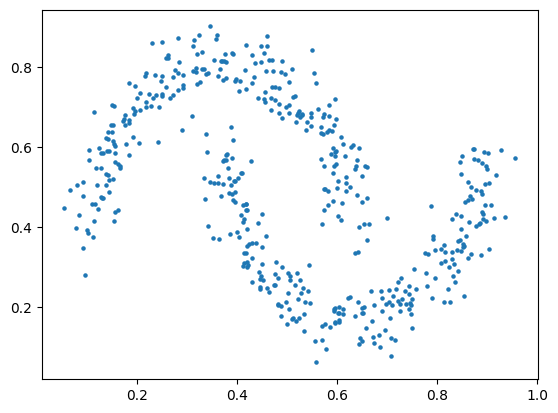

In [9]:
plt.scatter(dataset[0, :,0], dataset[0, :,1], s=5)

Construímos nosso NSF usando o mesmo número de camadas e unidades escondidas do caso anterior.

In [10]:
base_dist = StandardNormal(shape=[2])

num_layers = 5
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=2, hidden_features=4)) # hidden_features é o a quantidade de unidades escondidas na rede neural
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

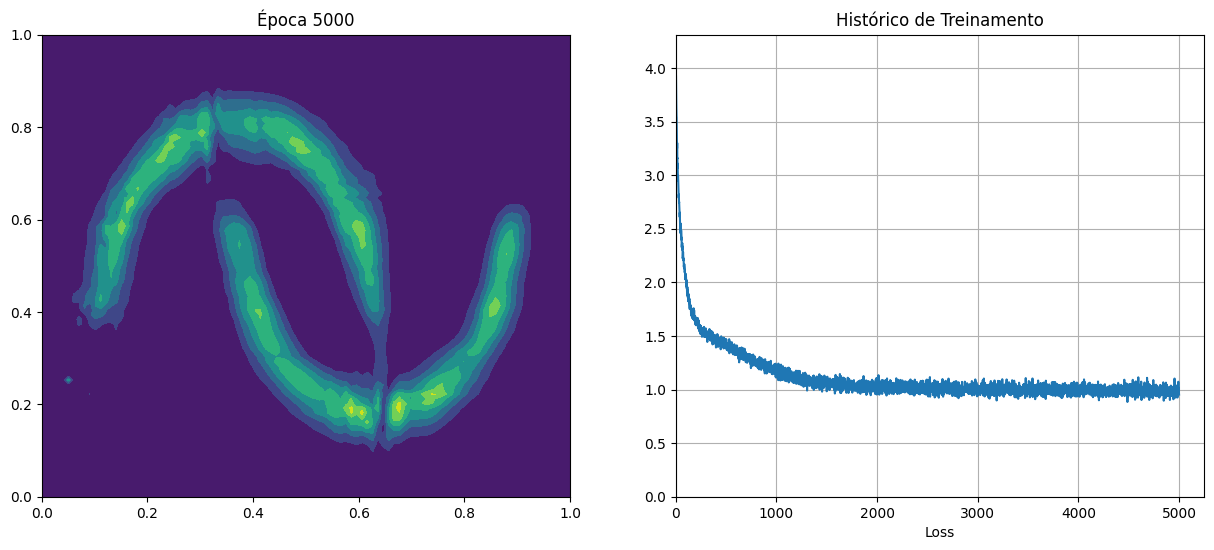

100%|██████████| 5000/5000 [04:01<00:00, 20.67it/s]


In [11]:
num_epochs = 5000
loss_history = []
nsf_density_plots = []

for i in tqdm(range(num_epochs)):
    x = dataset[i]
    x = torch.tensor(x, dtype=torch.float32) # transformamos em tensor do torch
    optimizer.zero_grad() # zeramos os gradientes do otimizador
    loss = -flow.log_prob(inputs=x).mean() # definimos a função loss como o inverso do log_prob médio calculado sobre a distribuição
    loss_history.append(loss.detach().numpy())
    loss.backward() # calcula os gradientes
    optimizer.step() # atualiza os pesos

    if (i+1) % 500 == 0: # a cada 500 épocas, fazemos um plot
        xline = torch.linspace(0, 1, 100)
        yline = torch.linspace(0, 1, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

        plot = plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        nsf_density_plots.append(plot)

        ax[0].contourf(plot)
        ax[0].set_title('Época {}'.format(i + 1))

        ax[1].plot(loss_history)
        ax[1].set_title("Histórico de Treinamento")
        ax[1].set_xlabel("Épocas")
        ax[1].set_xlabel("Loss")
        ax[1].grid()

        display.clear_output(wait=True)
        display.display(plt.gcf())
        #plt.show()
        plt.close()

Usando a mesma quantidade de épocas do caso anterior, o NSF é capaz de oferecer uma densidade de probabilidade mais acurada e bem definida devido a sua maior expressividade, mas o treinamento leva mais tempo. Podemos ver a evolução da distribuição modelada nos dois casos:

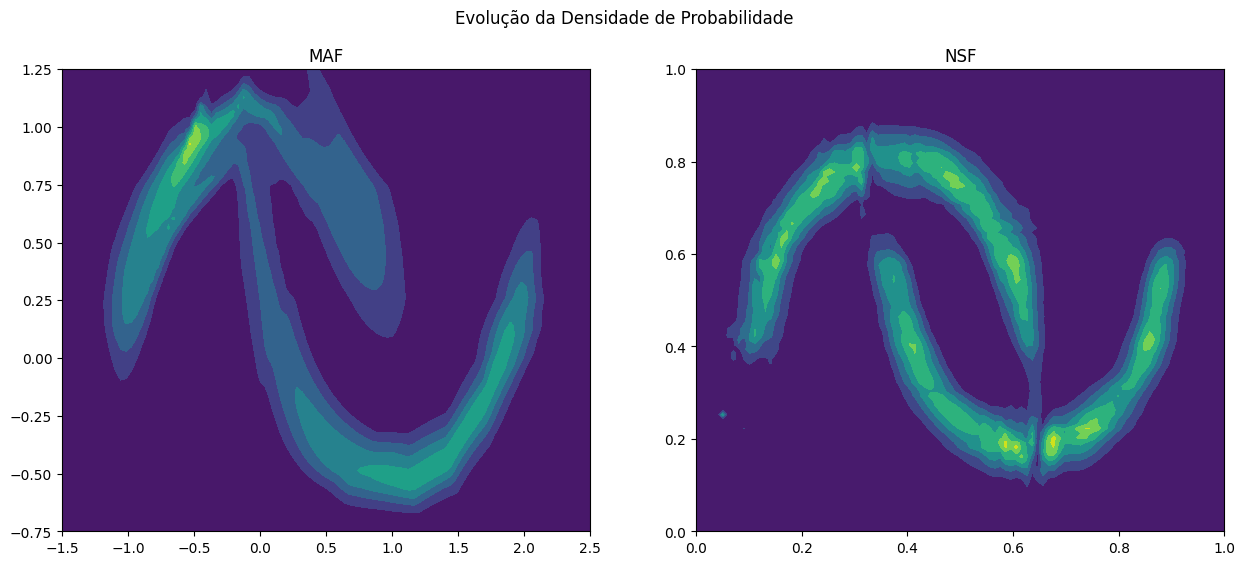

In [15]:
for i, _ in enumerate(maf_density_plots):
    fig, ax = plt.subplots(1, 2, figsize = [15, 6])
    plt.suptitle("Evolução da Densidade de Probabilidade")

    ax[0].contourf(maf_density_plots[i])
    ax[0].set_title("MAF")

    ax[1].contourf(nsf_density_plots[i])
    ax[1].set_title("NSF")

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

# Desafio NSF

In [6]:
from PIL import Image

In [ ]:
def make_logo_CBPF(n_samples):
    img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/cartaz-da-escola-2019-500x300.png"
    im = Image.open(img_path)
    arr = np.array(im) # transforma imagem em array

    max2 = np.max(arr, axis=2) # refaz a imagem em úma única banda pegando o maior valor dentre as 4

    print(arr.shape)

    pts = []
    w, h = max2.shape
    while len(pts) < 5000:
        pt = np.random.rand(2).astype('f') # gera par de números entre 0 e 1 (coordenadas)
        x = int((1 - pt[1]) * w) # multiplica valor pela largura e altura (desnormaliza a coordenada)
        y = int((pt[0]) * h)
        if max2[x,y] > 200: # caso o ponto sorteado não seja branco na imagem de uma banda:
            #print(len(pts)/1e5)
            pts.append(pt) # salva o ponto, repete até ter 10 mil pontos

    pts = np.array(pts) # transforma em array

    #pts -= np.mean(pts, axis=0)
    #pts *= 5
    #pts.shape

    plt.scatter(pts[:,0], pts[:,1], s=1)
    plt.axis('equal')
    plt.show()

In [2]:
base_dist = StandardNormal(shape=[2])
num_layers = 5
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=2, hidden_features=64)) # hidden_features é o a quantidade de unidades escondidas na rede neural
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

(300, 500, 4)


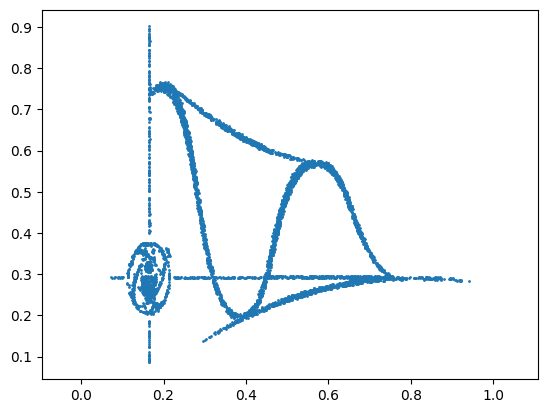

In [26]:
#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/letras_cbpf.png"
#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/Logo_CBPF_Sigla.png"
#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/49055715328_092031af74_o.png"
img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/cartaz-da-escola-2019-500x300.png"

im = Image.open(img_path)
arr = np.array(im) # transforma imagem em array

max2 = np.max(arr, axis=2) # refaz a imagem em úma única banda pegando o maior valor dentre as 4

print(arr.shape)

pts = []
w, h = max2.shape
while len(pts) < 5000:
    pt = np.random.rand(2).astype('f') # gera par de números entre 0 e 1 (coordenadas)
    x = int((1 - pt[1]) * w) # multiplica valor pela largura e altura (desnormaliza a coordenada)
    y = int((pt[0]) * h)
    if max2[x,y] > 200: # caso o ponto sorteado não seja branco na imagem de uma banda:
        #print(len(pts)/1e5)
        pts.append(pt) # salva o ponto, repete até ter 10 mil pontos

pts = np.array(pts) # transforma em array

#pts -= np.mean(pts, axis=0)
#pts *= 5
#pts.shape

plt.scatter(pts[:,0], pts[:,1], s=1)
plt.axis('equal')
plt.show()

  1%|          | 49/5000 [00:11<17:16,  4.78it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


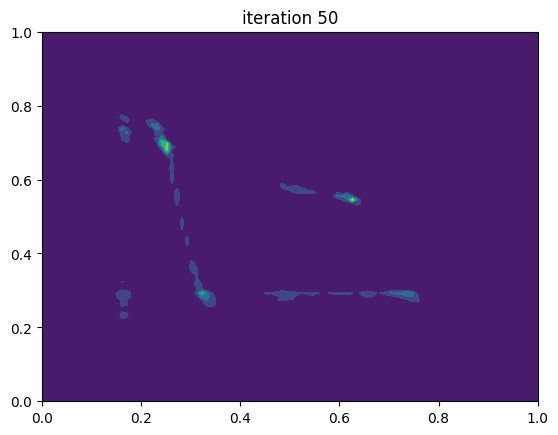

  2%|▏         | 99/5000 [00:23<17:07,  4.77it/s]

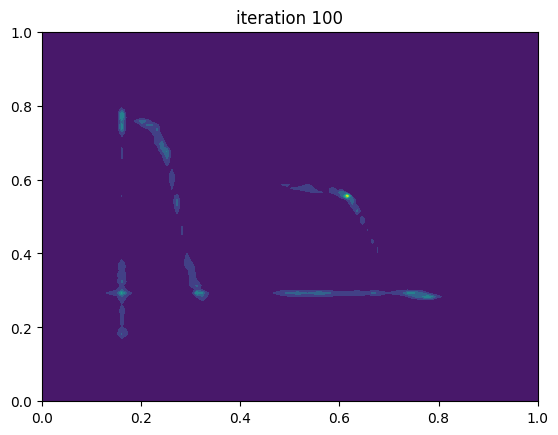

  3%|▎         | 149/5000 [00:36<16:40,  4.85it/s]

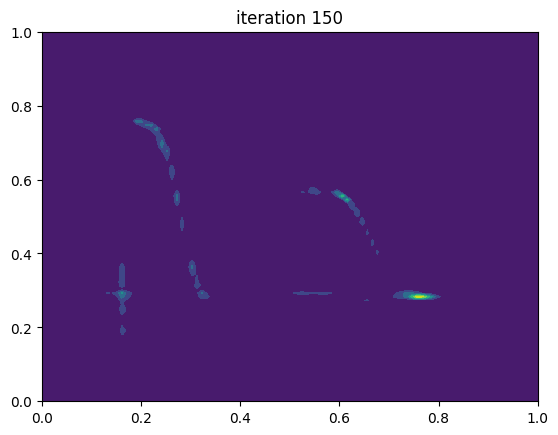

  4%|▍         | 199/5000 [00:48<17:52,  4.48it/s]

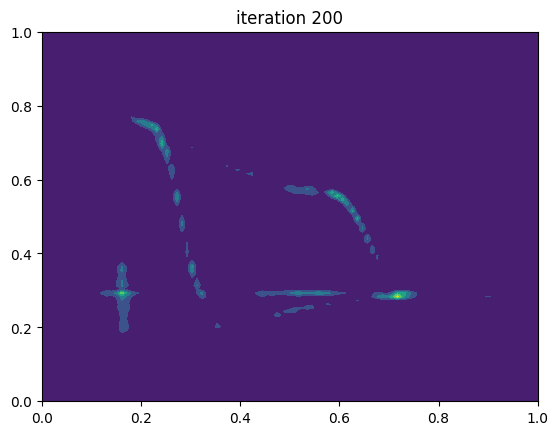

  5%|▍         | 249/5000 [01:00<23:39,  3.35it/s]

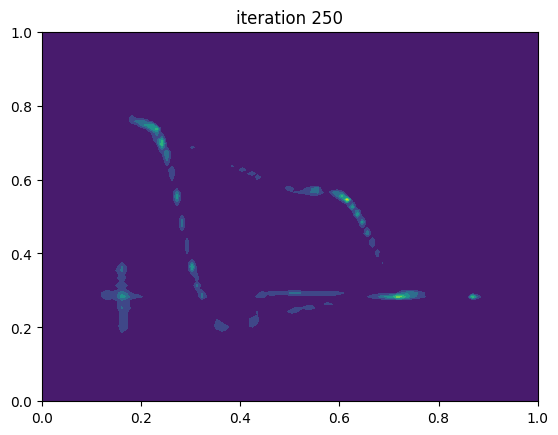

  6%|▌         | 299/5000 [01:11<16:07,  4.86it/s]

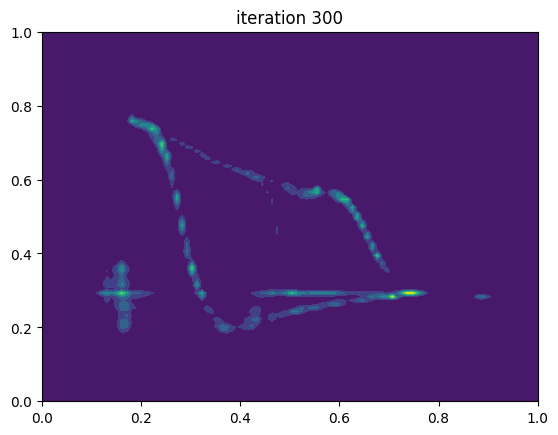

  7%|▋         | 349/5000 [01:24<16:08,  4.80it/s]

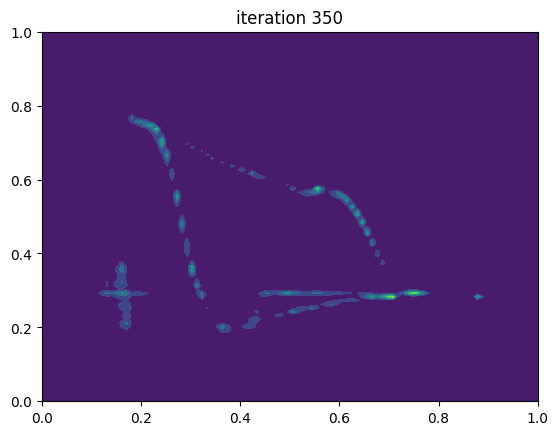

  8%|▊         | 399/5000 [01:36<15:56,  4.81it/s]

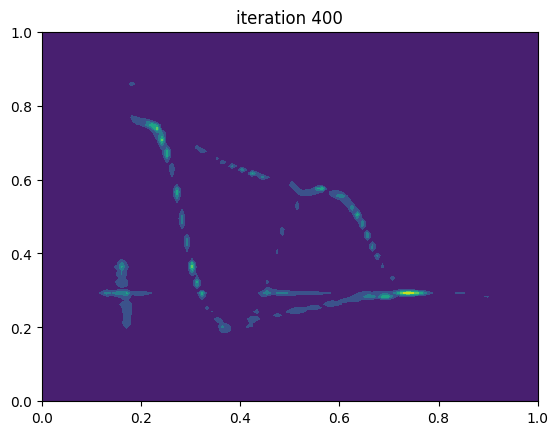

  9%|▉         | 449/5000 [01:48<15:50,  4.79it/s]

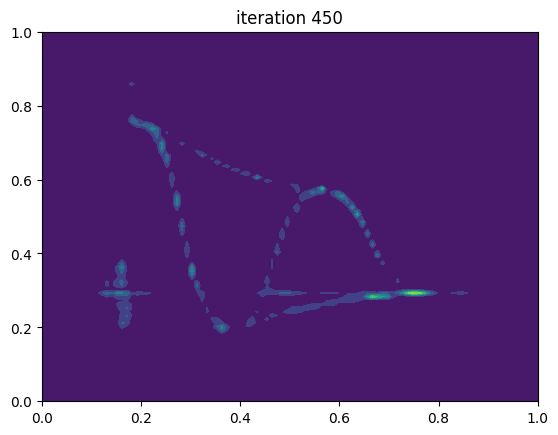

 10%|▉         | 499/5000 [02:01<17:01,  4.41it/s]

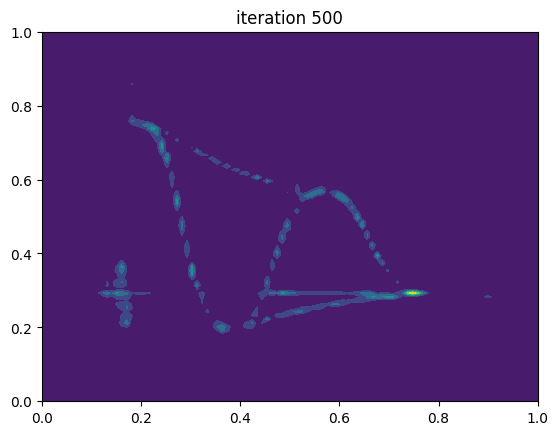

 11%|█         | 549/5000 [02:12<22:11,  3.34it/s]

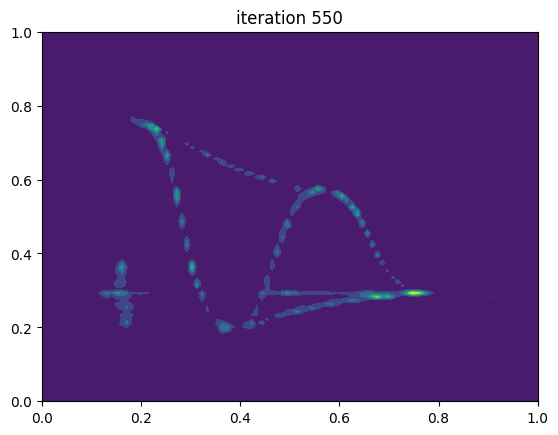

 12%|█▏        | 599/5000 [02:24<15:20,  4.78it/s]

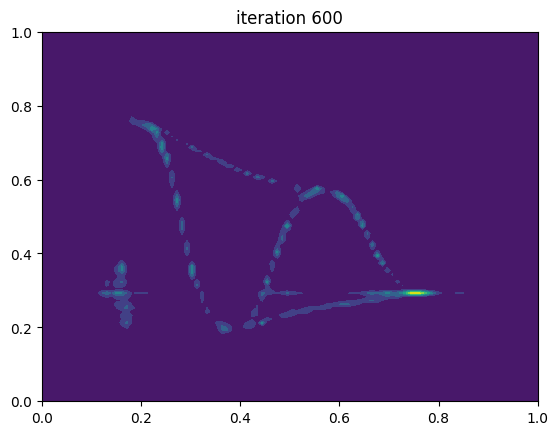

 13%|█▎        | 649/5000 [02:37<15:30,  4.68it/s]

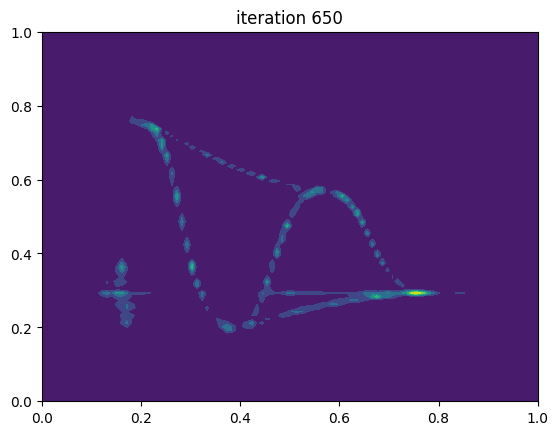

 14%|█▍        | 699/5000 [02:49<14:57,  4.79it/s]

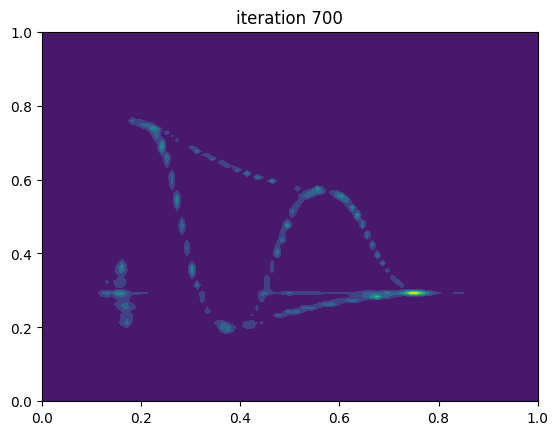

 15%|█▍        | 749/5000 [03:02<15:33,  4.56it/s]

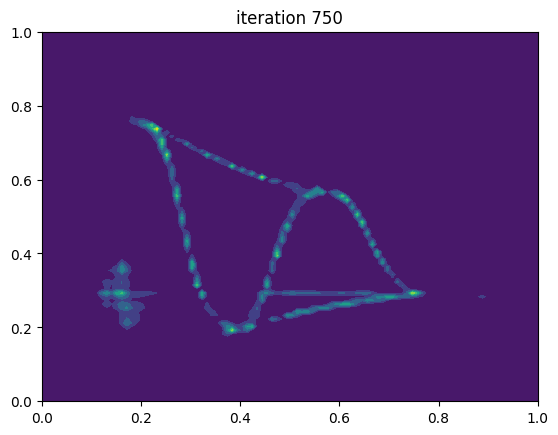

 16%|█▌        | 799/5000 [03:14<15:56,  4.39it/s]

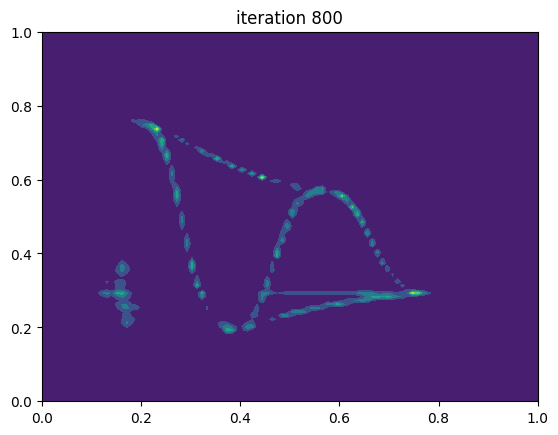

 17%|█▋        | 849/5000 [03:26<21:35,  3.20it/s]

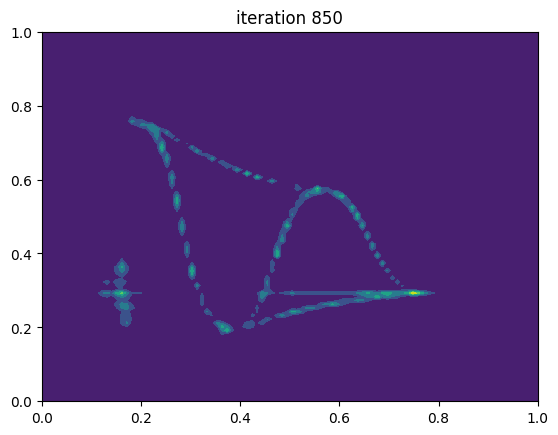

 18%|█▊        | 899/5000 [03:38<15:40,  4.36it/s]

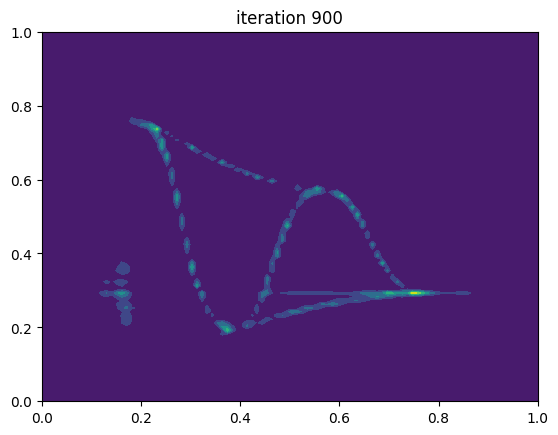

 19%|█▉        | 949/5000 [03:50<14:01,  4.81it/s]

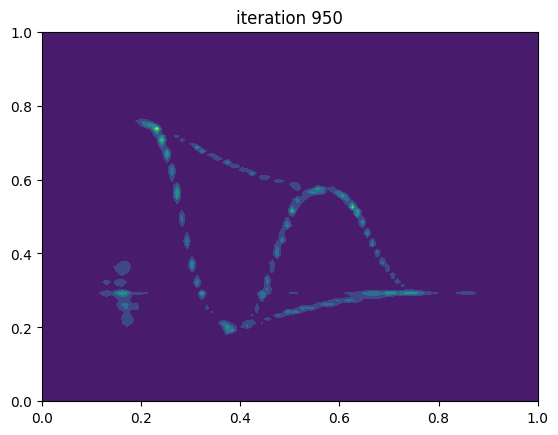

 20%|█▉        | 999/5000 [04:03<14:20,  4.65it/s]

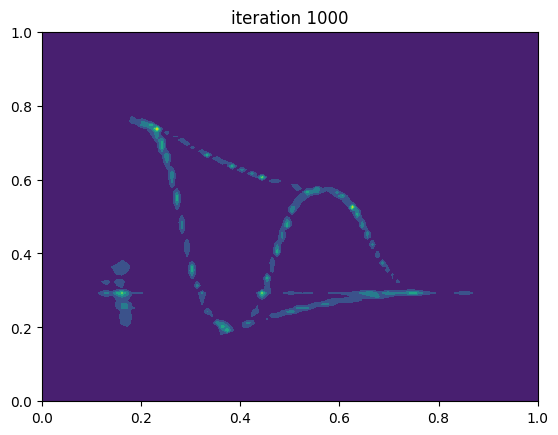

 21%|██        | 1049/5000 [04:16<14:17,  4.61it/s]

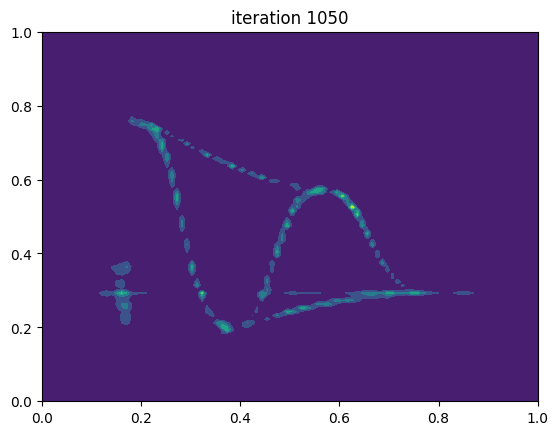

 22%|██▏       | 1099/5000 [04:28<14:23,  4.52it/s]

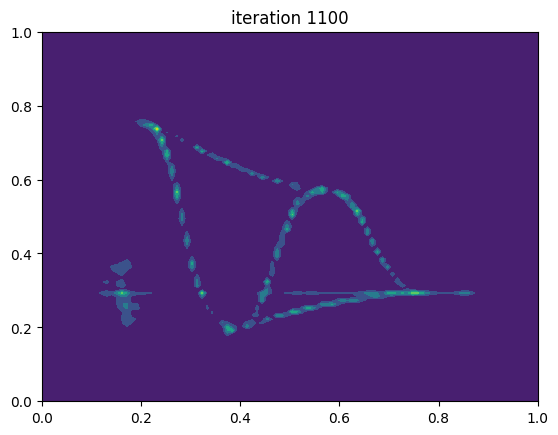

 23%|██▎       | 1149/5000 [04:41<20:02,  3.20it/s]

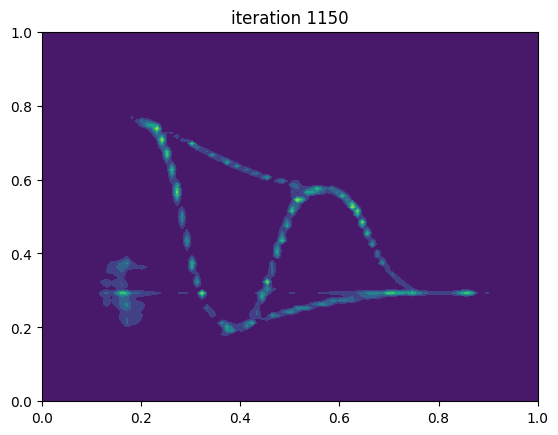

 24%|██▍       | 1199/5000 [04:53<19:01,  3.33it/s]

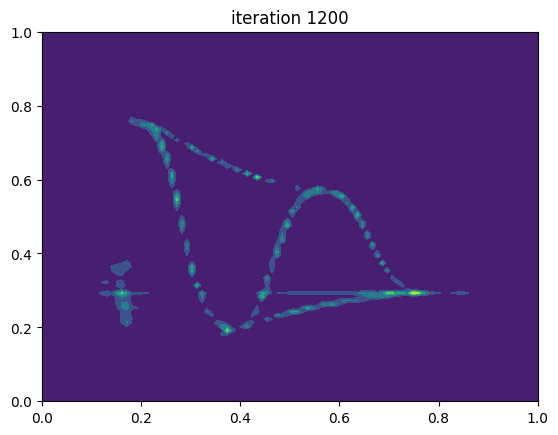

 25%|██▍       | 1249/5000 [05:05<13:30,  4.63it/s]

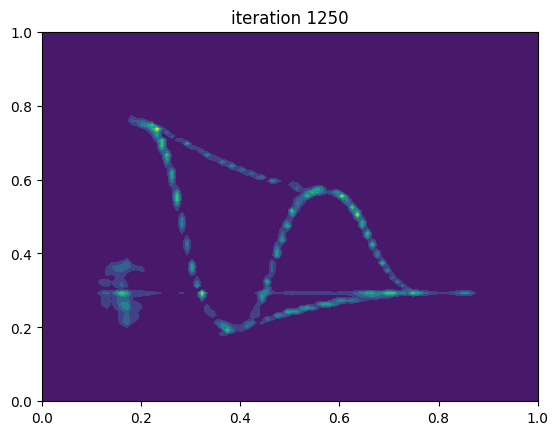

 26%|██▌       | 1299/5000 [05:18<13:18,  4.64it/s]

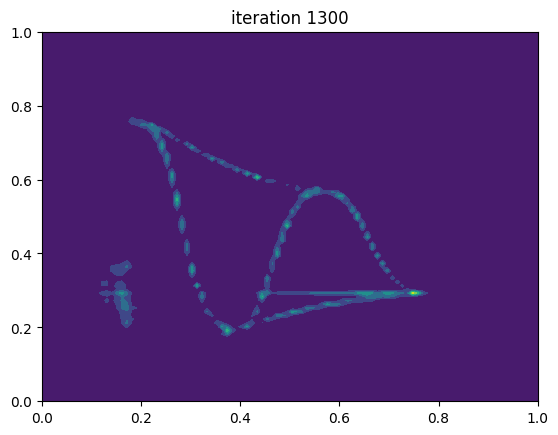

 27%|██▋       | 1349/5000 [05:31<13:25,  4.53it/s]

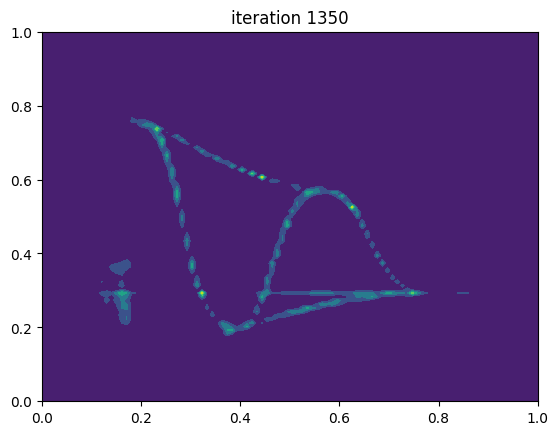

 28%|██▊       | 1399/5000 [05:44<13:04,  4.59it/s]

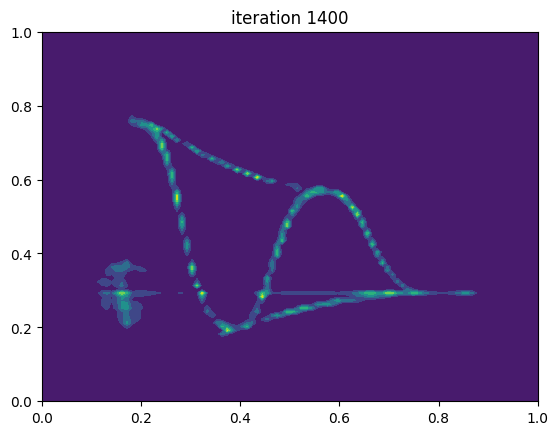

 29%|██▉       | 1449/5000 [05:56<13:36,  4.35it/s]

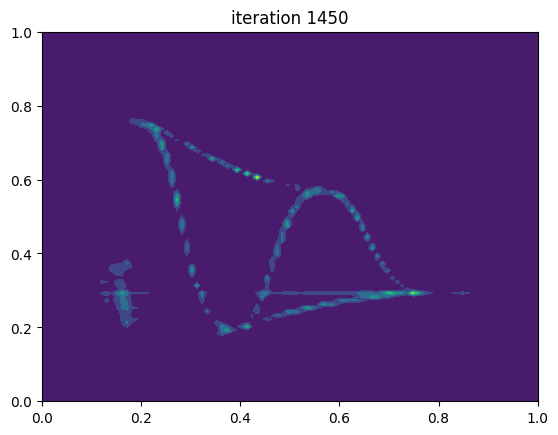

 30%|██▉       | 1499/5000 [06:09<18:44,  3.11it/s]

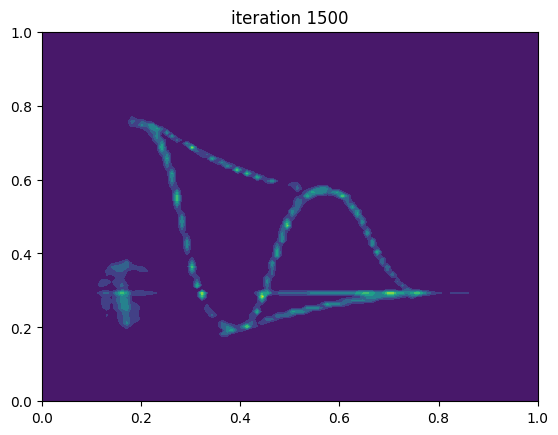

 31%|███       | 1549/5000 [06:21<16:48,  3.42it/s]

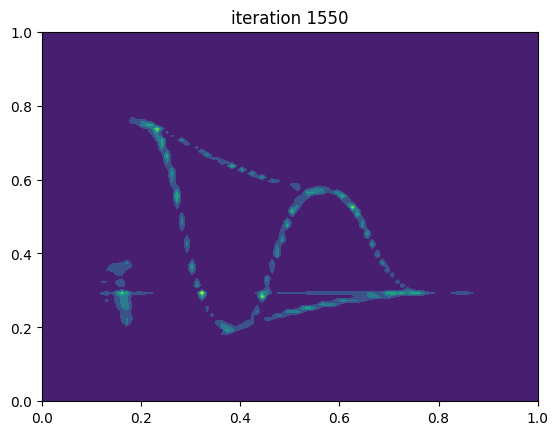

 32%|███▏      | 1599/5000 [06:33<12:13,  4.63it/s]

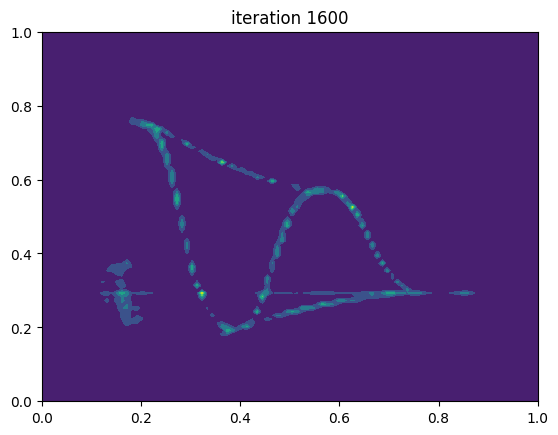

 33%|███▎      | 1649/5000 [06:46<12:11,  4.58it/s]

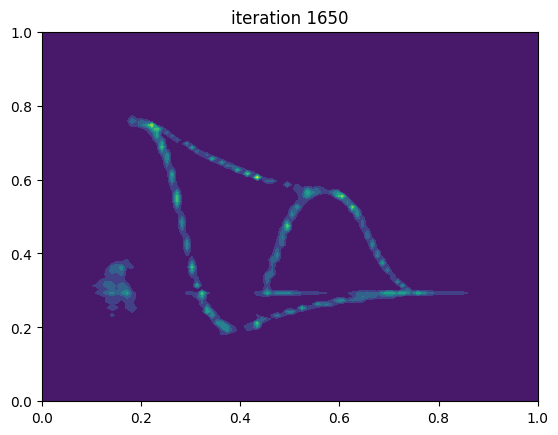

 34%|███▍      | 1699/5000 [06:59<11:58,  4.59it/s]

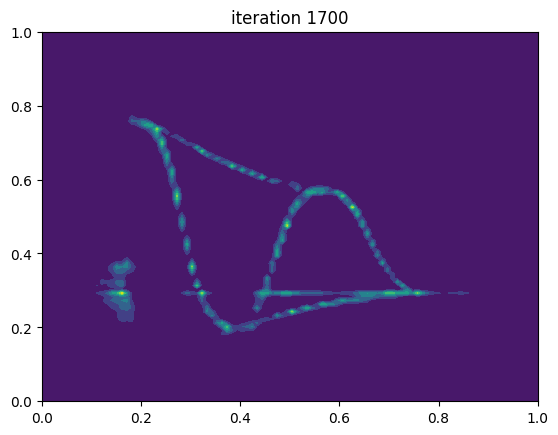

 35%|███▍      | 1749/5000 [07:12<11:46,  4.60it/s]

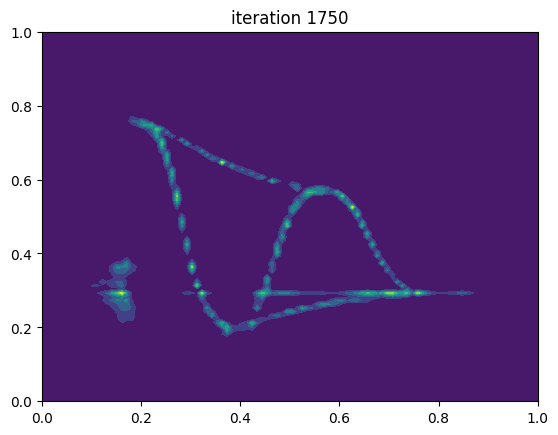

 36%|███▌      | 1799/5000 [07:24<12:12,  4.37it/s]

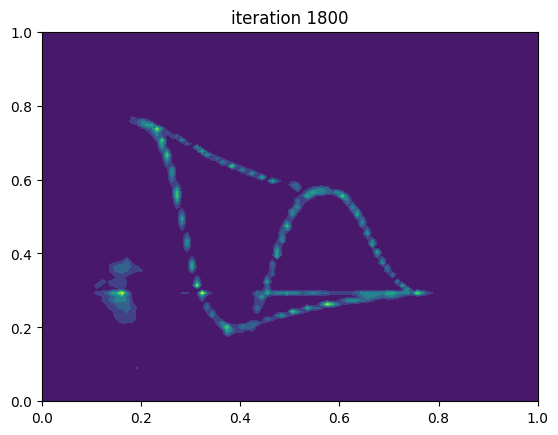

 37%|███▋      | 1849/5000 [07:37<16:09,  3.25it/s]

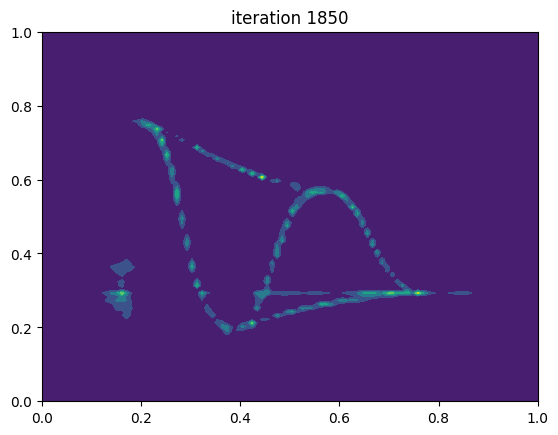

 38%|███▊      | 1899/5000 [07:49<15:18,  3.38it/s]

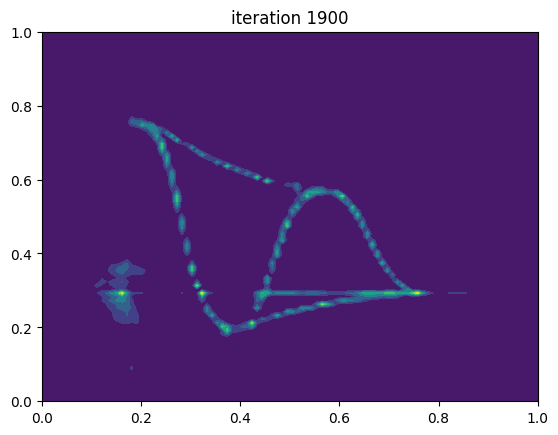

 39%|███▉      | 1949/5000 [08:02<11:10,  4.55it/s]

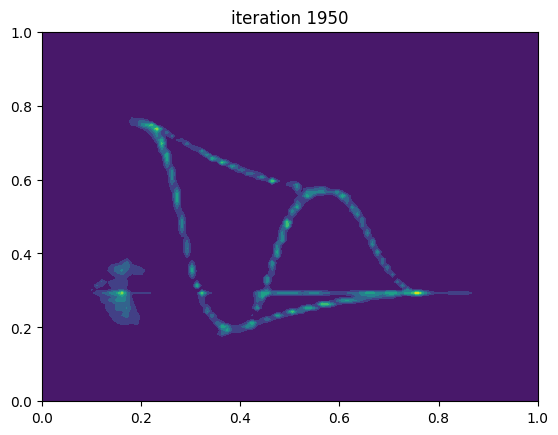

 40%|███▉      | 1999/5000 [08:15<11:03,  4.52it/s]

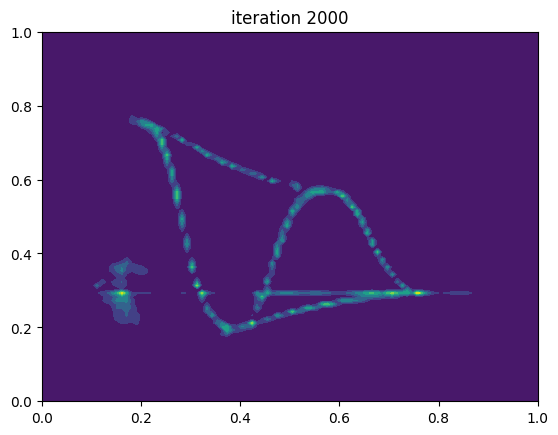

 41%|████      | 2049/5000 [08:27<10:53,  4.52it/s]

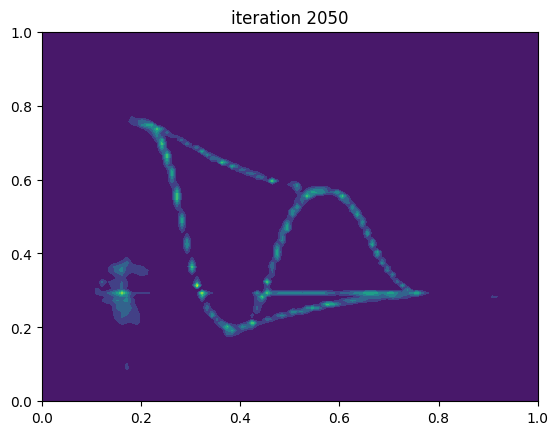

 42%|████▏     | 2099/5000 [08:40<10:49,  4.47it/s]

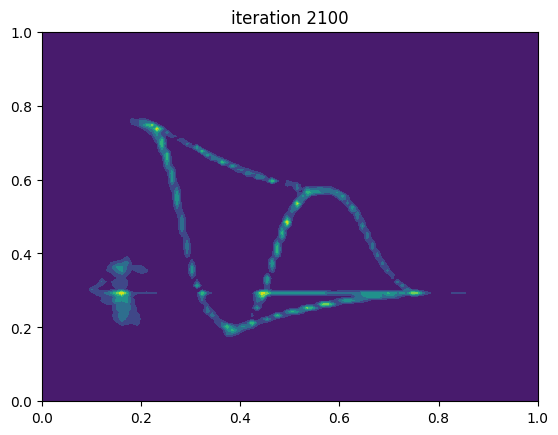

 43%|████▎     | 2149/5000 [08:53<10:52,  4.37it/s]

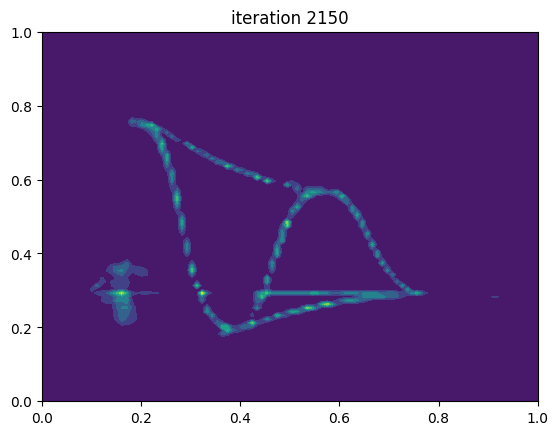

 44%|████▍     | 2199/5000 [09:06<14:17,  3.27it/s]

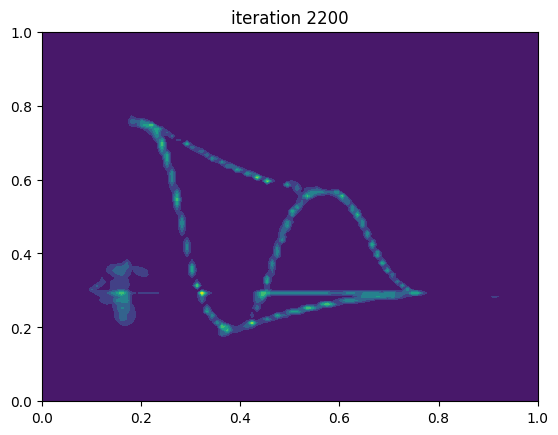

 45%|████▍     | 2249/5000 [09:18<14:09,  3.24it/s]

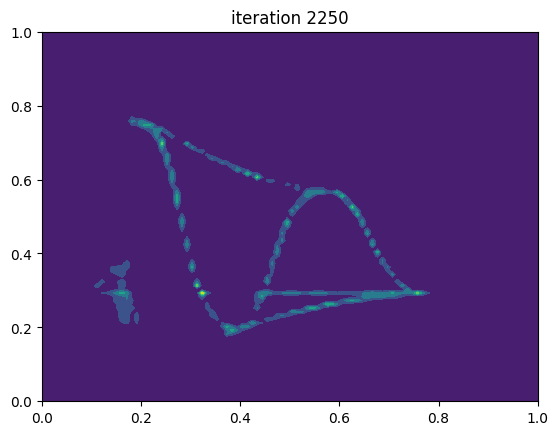

 46%|████▌     | 2299/5000 [09:31<09:50,  4.57it/s]

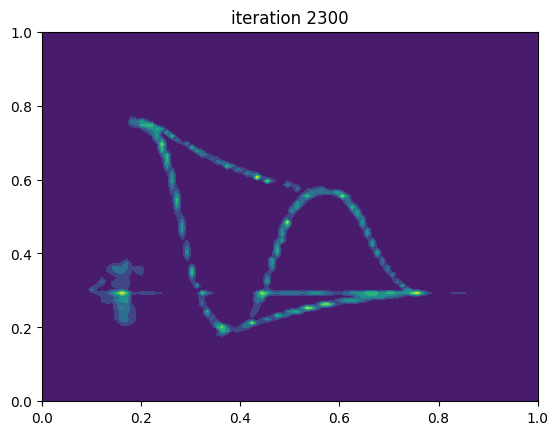

 47%|████▋     | 2349/5000 [09:43<09:45,  4.53it/s]

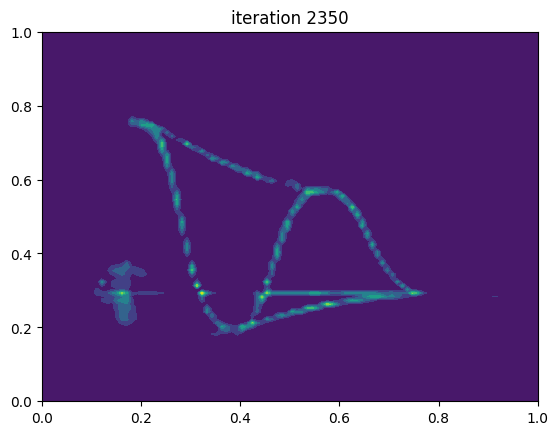

 48%|████▊     | 2399/5000 [09:56<09:49,  4.41it/s]

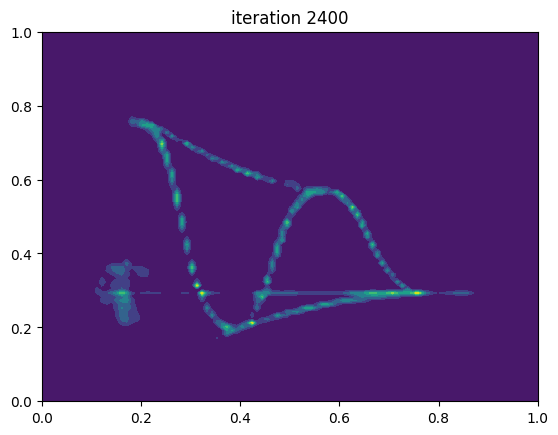

 49%|████▉     | 2449/5000 [10:09<09:27,  4.50it/s]

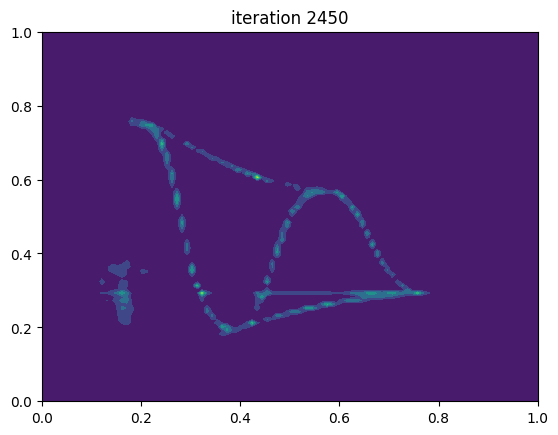

 50%|████▉     | 2499/5000 [10:22<09:32,  4.37it/s]

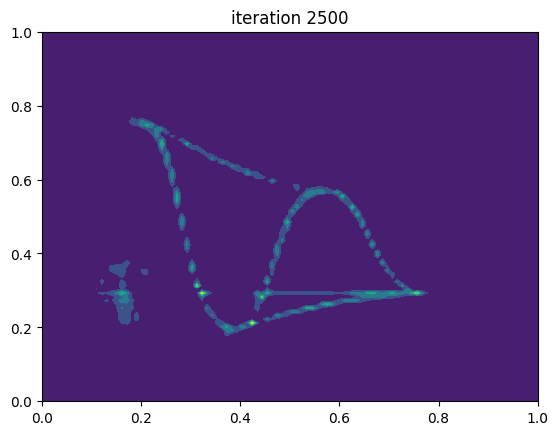

 51%|█████     | 2549/5000 [10:35<12:06,  3.37it/s]

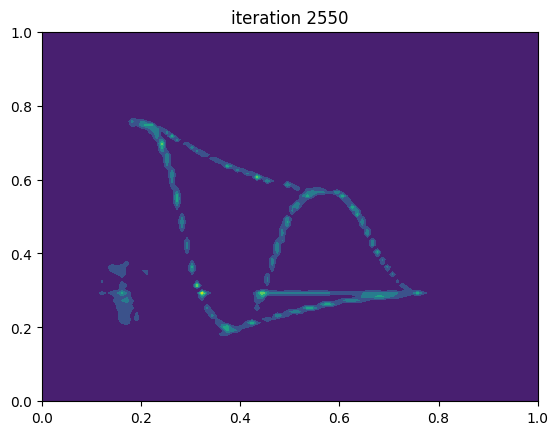

 52%|█████▏    | 2599/5000 [10:47<12:20,  3.24it/s]

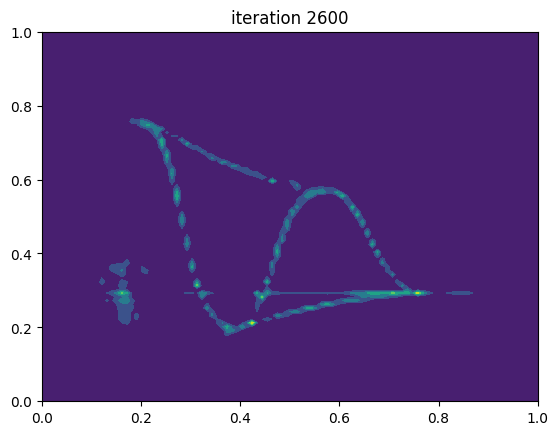

 53%|█████▎    | 2649/5000 [11:00<08:38,  4.53it/s]

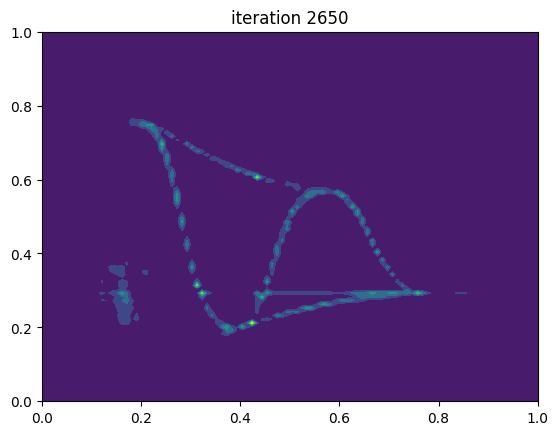

 54%|█████▍    | 2699/5000 [11:13<08:21,  4.59it/s]

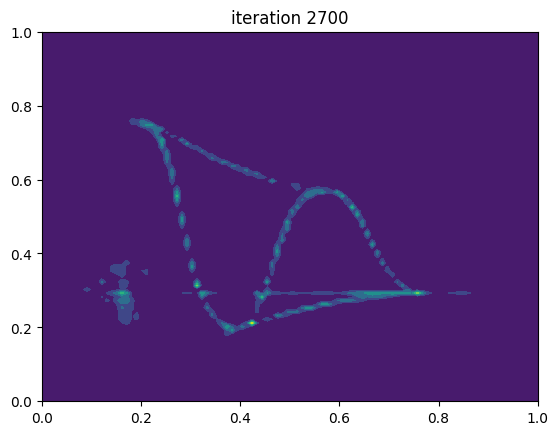

 55%|█████▍    | 2749/5000 [11:26<08:24,  4.46it/s]

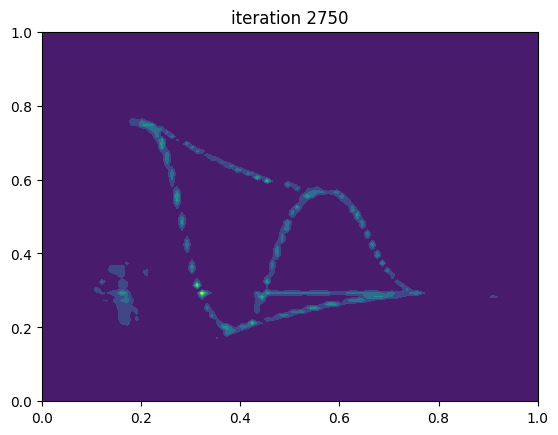

 56%|█████▌    | 2799/5000 [11:39<08:06,  4.53it/s]

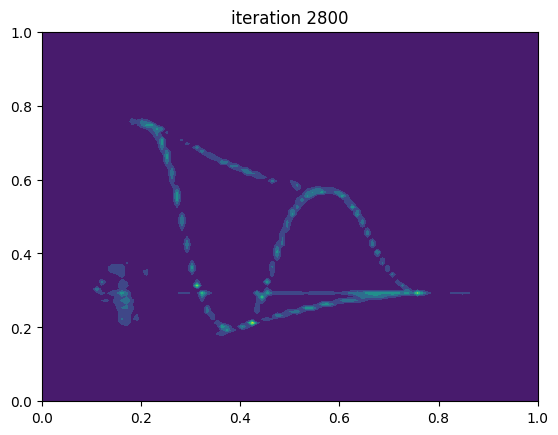

 57%|█████▋    | 2849/5000 [11:52<08:06,  4.42it/s]

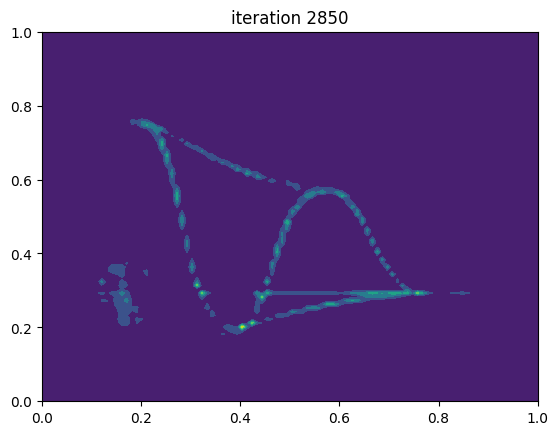

 58%|█████▊    | 2899/5000 [12:05<08:46,  3.99it/s]

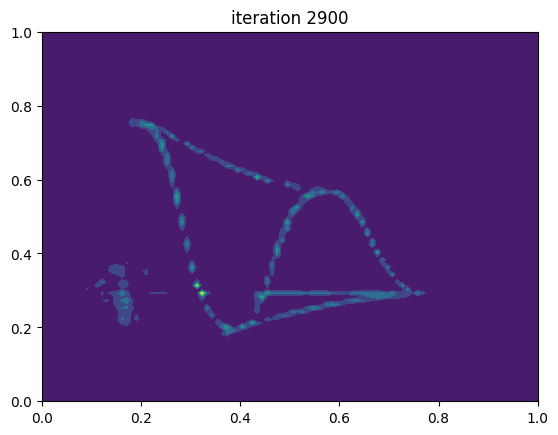

 59%|█████▉    | 2949/5000 [12:18<11:03,  3.09it/s]

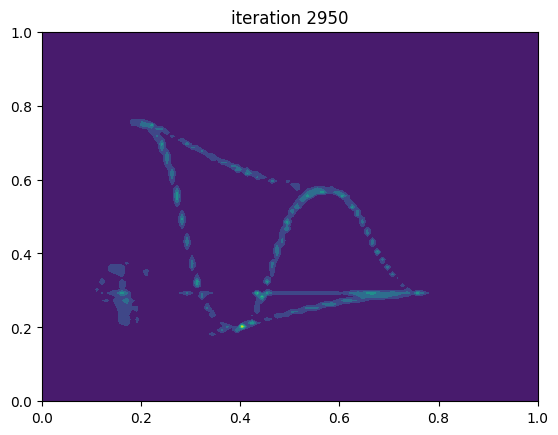

 60%|█████▉    | 2999/5000 [12:30<09:51,  3.38it/s]

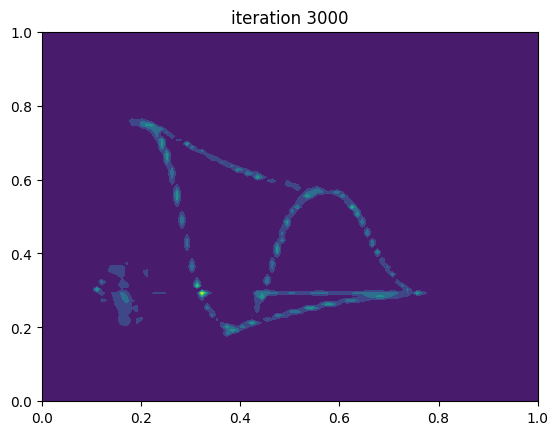

 61%|██████    | 3049/5000 [12:43<07:17,  4.46it/s]

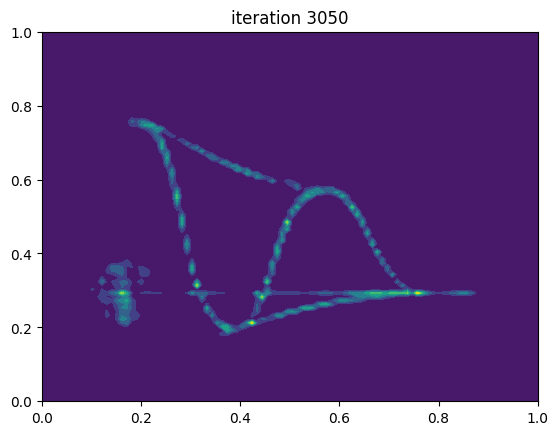

 62%|██████▏   | 3099/5000 [12:56<07:21,  4.31it/s]

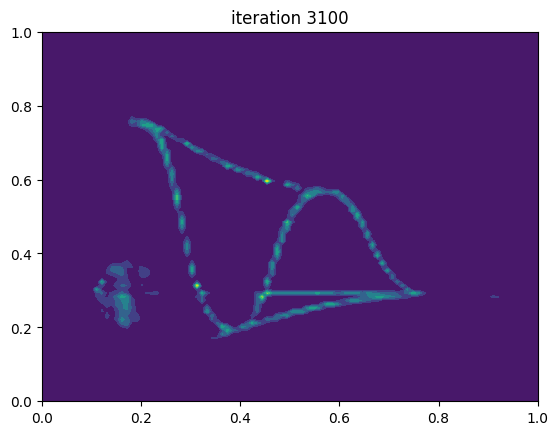

 63%|██████▎   | 3149/5000 [13:09<06:55,  4.45it/s]

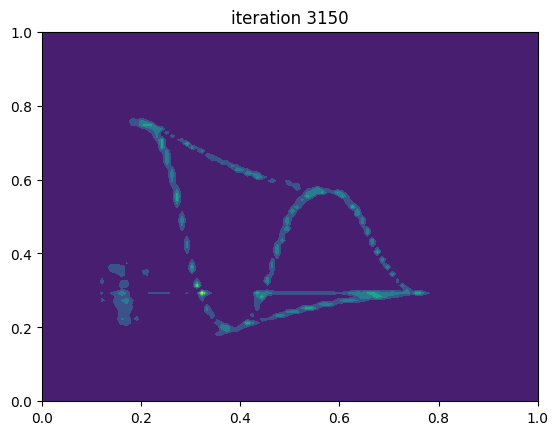

 64%|██████▍   | 3199/5000 [13:23<06:41,  4.49it/s]

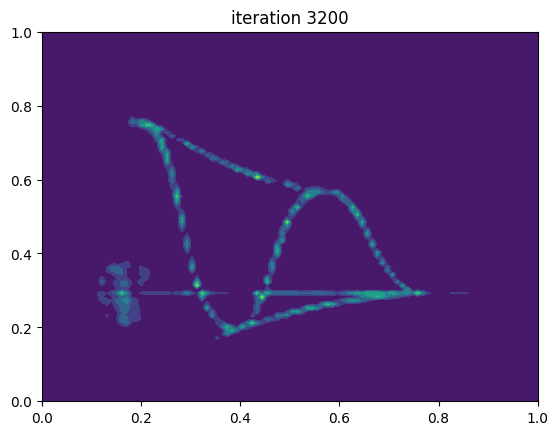

 65%|██████▍   | 3249/5000 [13:36<06:36,  4.41it/s]

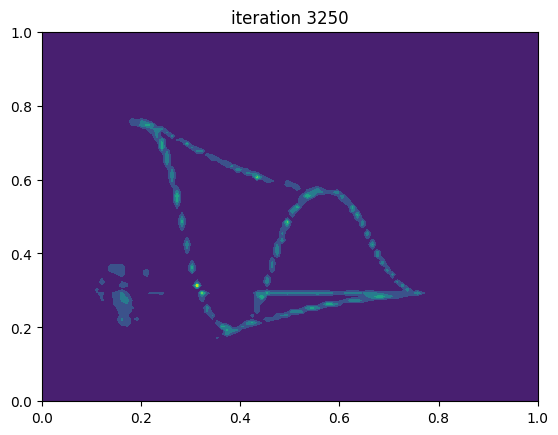

 66%|██████▌   | 3299/5000 [13:49<07:52,  3.60it/s]

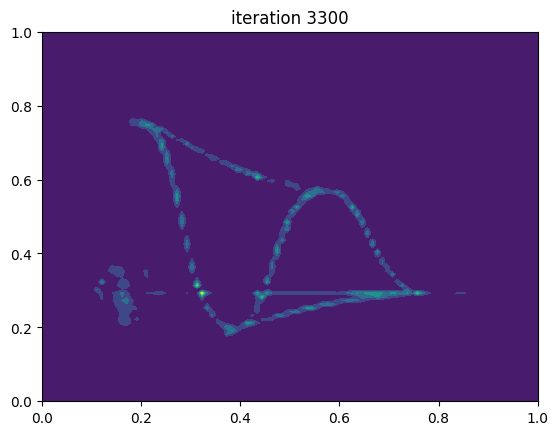

 67%|██████▋   | 3349/5000 [14:01<08:34,  3.21it/s]

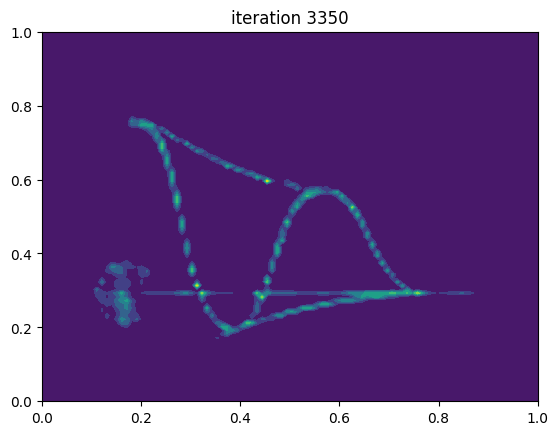

 68%|██████▊   | 3399/5000 [14:14<06:42,  3.98it/s]

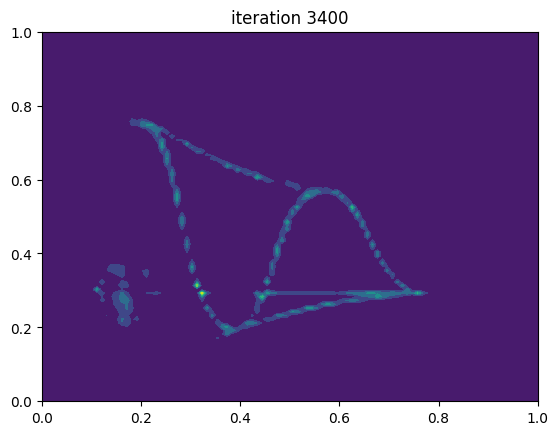

 69%|██████▉   | 3449/5000 [14:26<05:40,  4.56it/s]

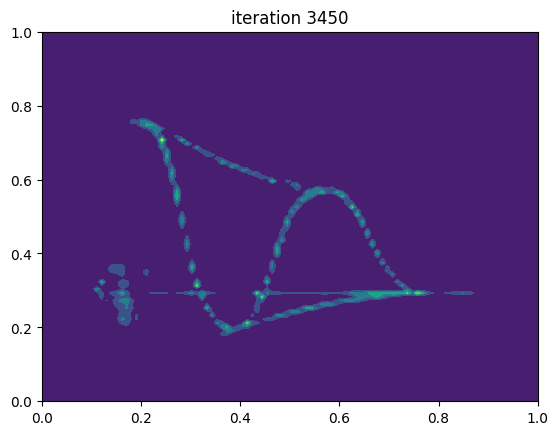

 70%|██████▉   | 3499/5000 [14:39<05:28,  4.57it/s]

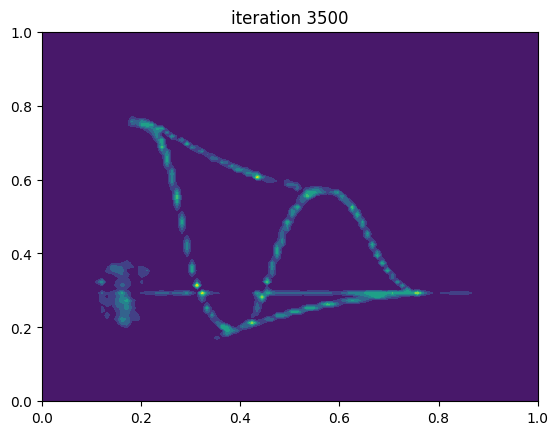

 71%|███████   | 3549/5000 [14:52<05:23,  4.49it/s]

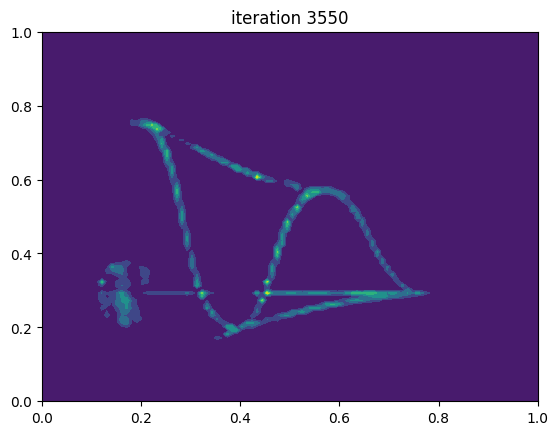

 72%|███████▏  | 3599/5000 [15:05<05:13,  4.48it/s]

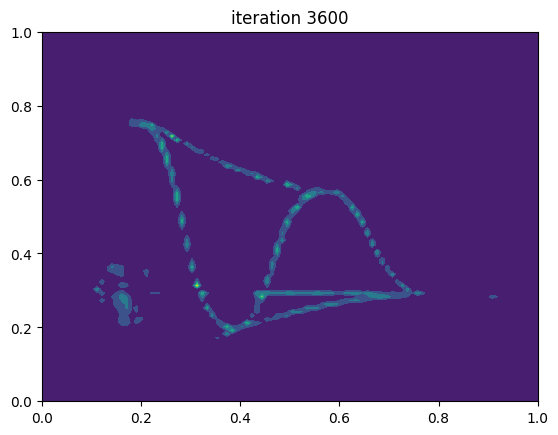

 73%|███████▎  | 3649/5000 [15:18<06:03,  3.72it/s]

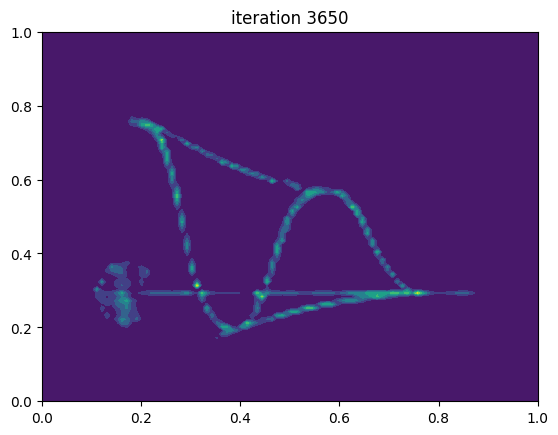

 74%|███████▍  | 3699/5000 [15:31<06:50,  3.17it/s]

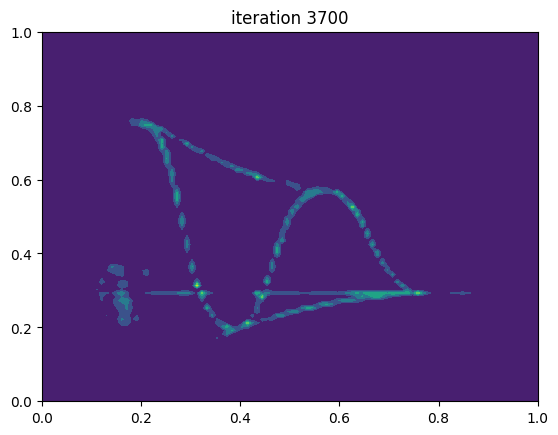

 75%|███████▍  | 3749/5000 [15:43<05:02,  4.14it/s]

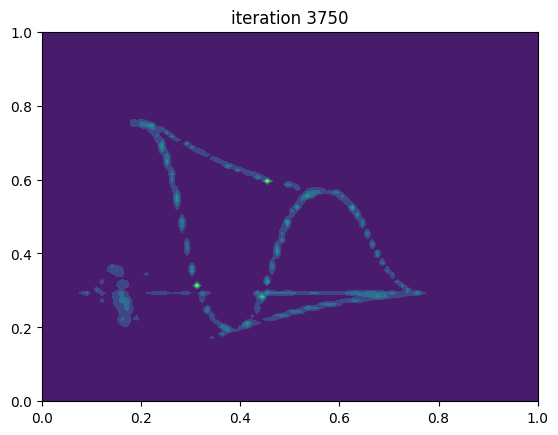

 76%|███████▌  | 3799/5000 [15:56<04:28,  4.47it/s]

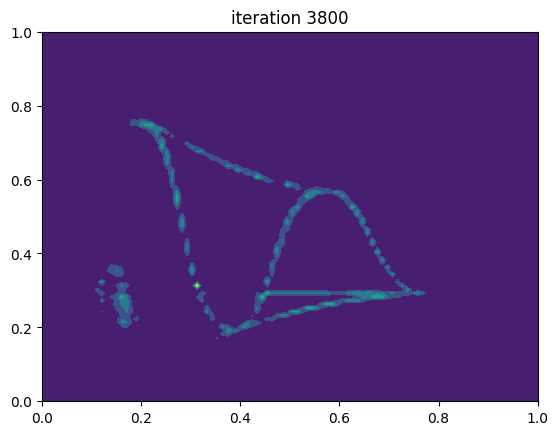

 77%|███████▋  | 3849/5000 [16:09<04:25,  4.33it/s]

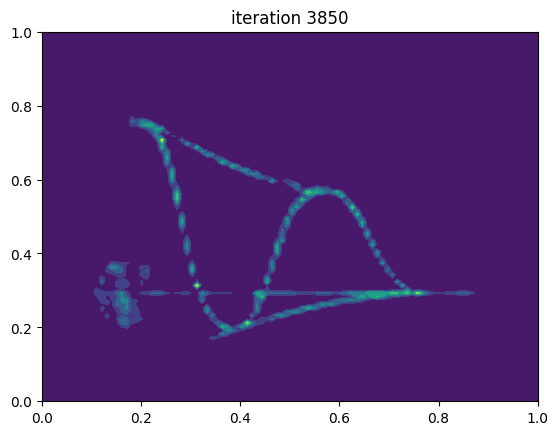

 78%|███████▊  | 3899/5000 [16:23<04:14,  4.33it/s]

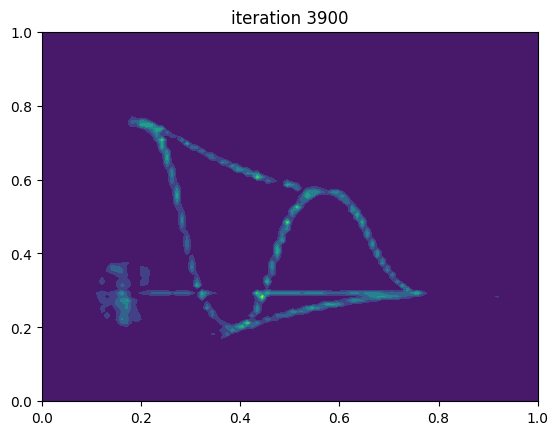

 79%|███████▉  | 3949/5000 [16:36<04:04,  4.29it/s]

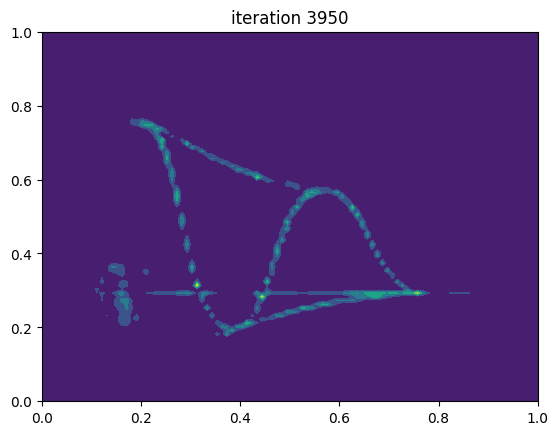

 80%|███████▉  | 3999/5000 [16:49<03:57,  4.22it/s]

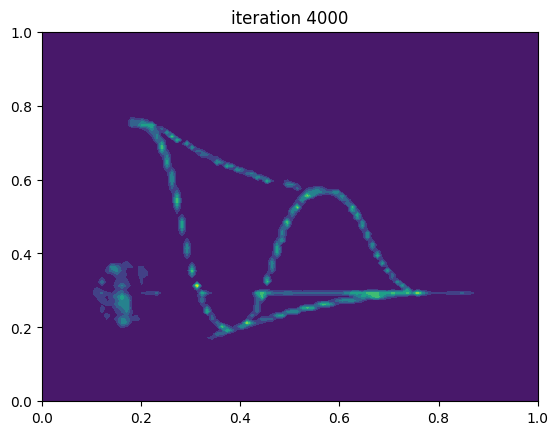

 81%|████████  | 4049/5000 [17:02<05:02,  3.15it/s]

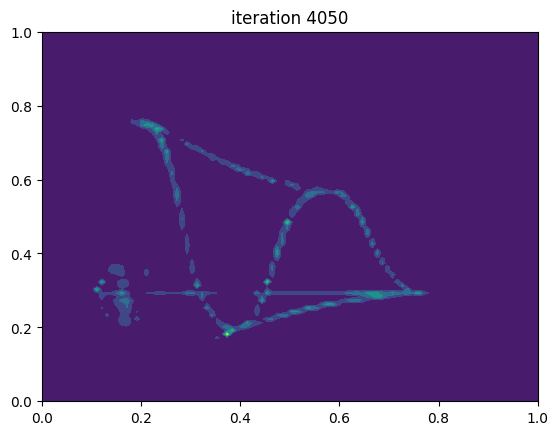

 82%|████████▏ | 4099/5000 [17:15<04:33,  3.29it/s]

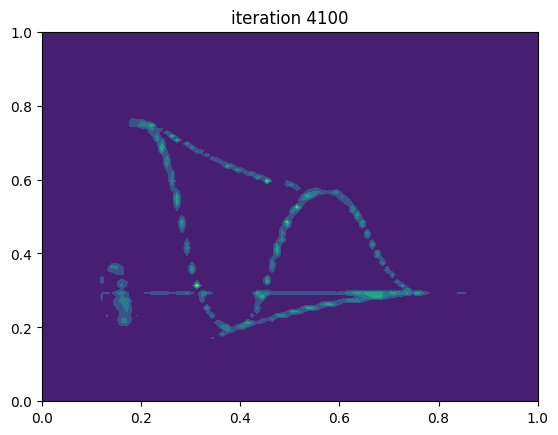

 83%|████████▎ | 4149/5000 [17:27<03:13,  4.39it/s]

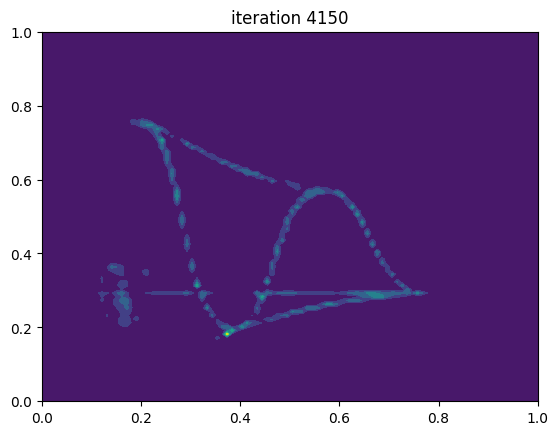

 84%|████████▍ | 4199/5000 [17:40<03:06,  4.30it/s]

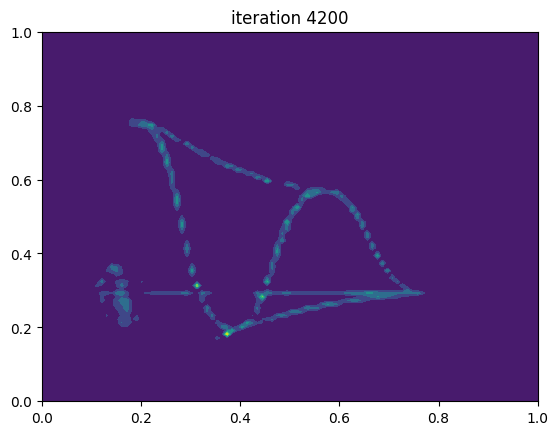

 85%|████████▍ | 4249/5000 [17:54<02:52,  4.36it/s]

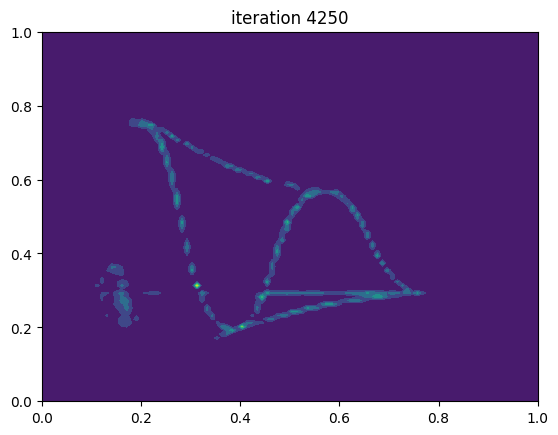

 86%|████████▌ | 4299/5000 [18:07<02:36,  4.49it/s]

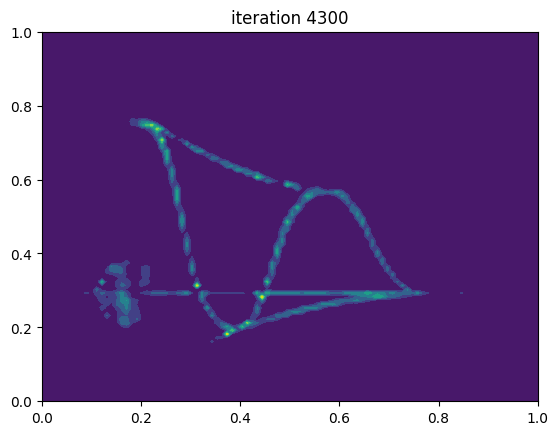

 87%|████████▋ | 4349/5000 [18:20<02:25,  4.46it/s]

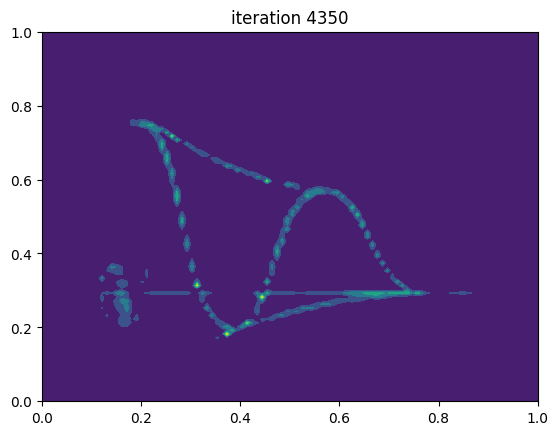

 88%|████████▊ | 4399/5000 [18:33<02:52,  3.48it/s]

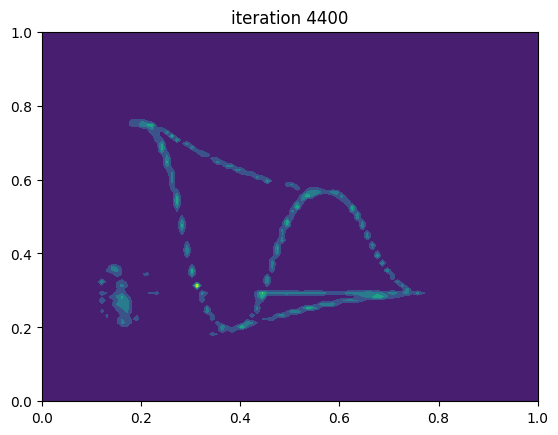

 89%|████████▉ | 4449/5000 [18:45<02:51,  3.21it/s]

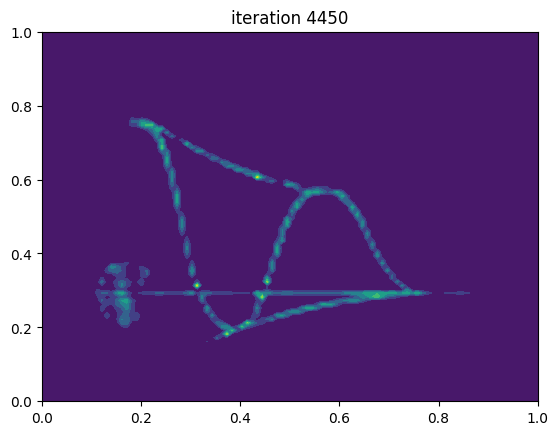

 90%|████████▉ | 4499/5000 [18:58<02:04,  4.03it/s]

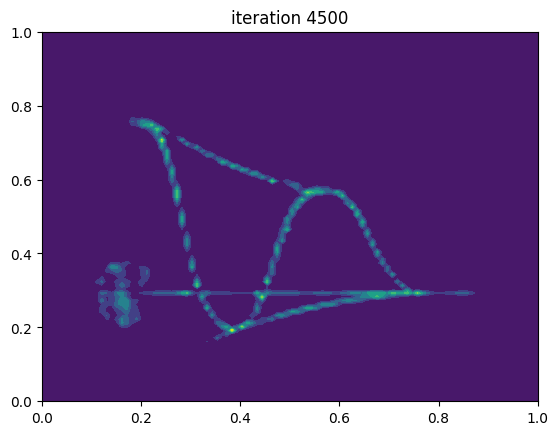

 91%|█████████ | 4549/5000 [19:11<01:45,  4.29it/s]

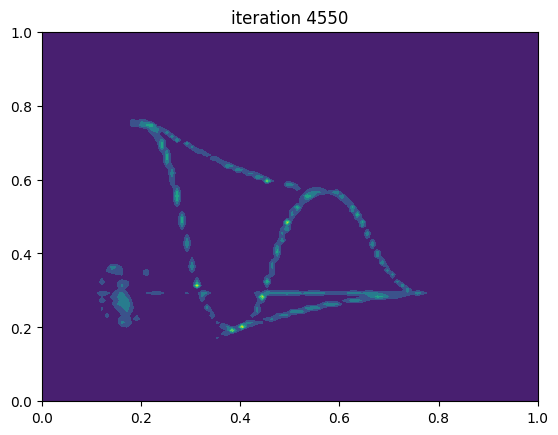

 92%|█████████▏| 4599/5000 [19:24<01:31,  4.38it/s]

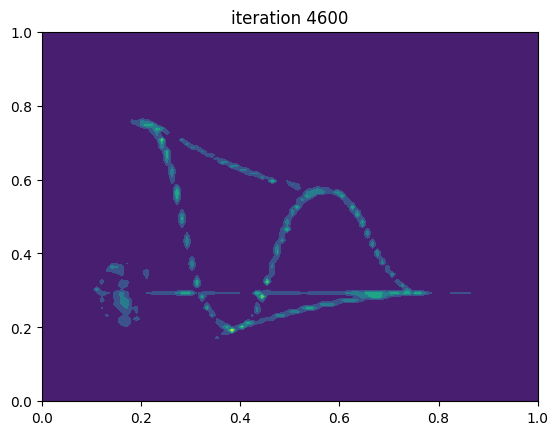

 93%|█████████▎| 4649/5000 [19:37<01:18,  4.47it/s]

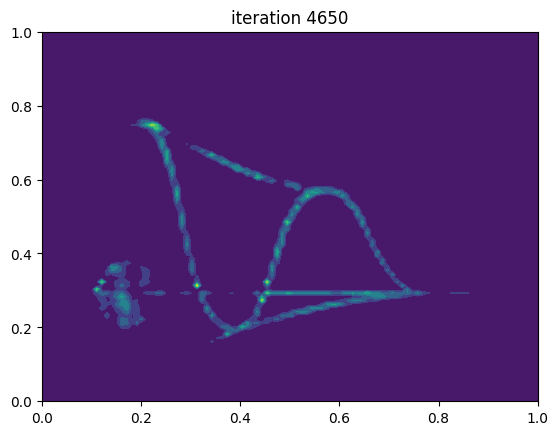

 94%|█████████▍| 4699/5000 [19:50<01:08,  4.40it/s]

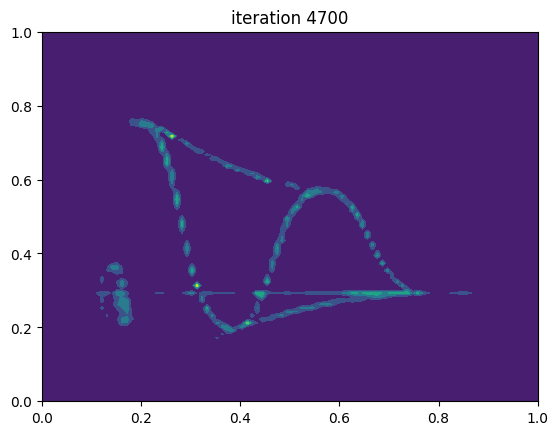

 95%|█████████▍| 4749/5000 [20:03<01:04,  3.90it/s]

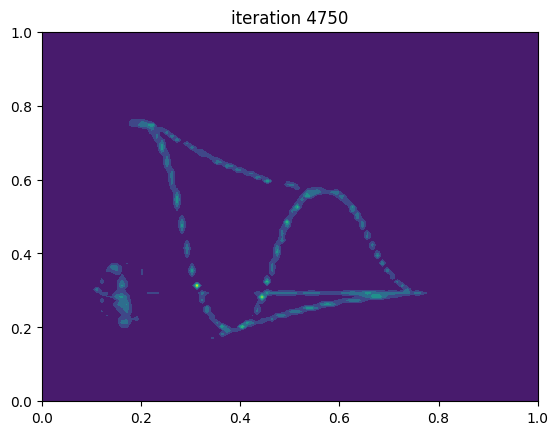

 96%|█████████▌| 4799/5000 [20:16<01:03,  3.17it/s]

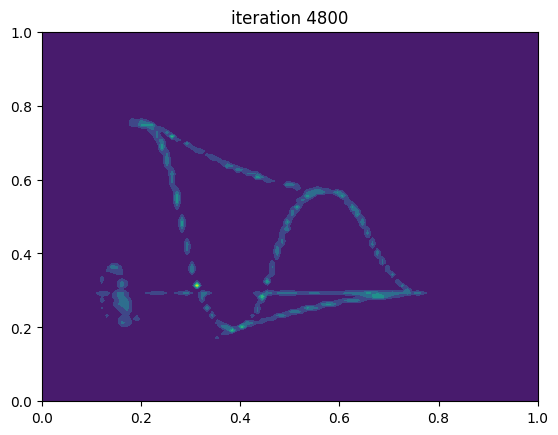

 97%|█████████▋| 4849/5000 [20:28<00:40,  3.70it/s]

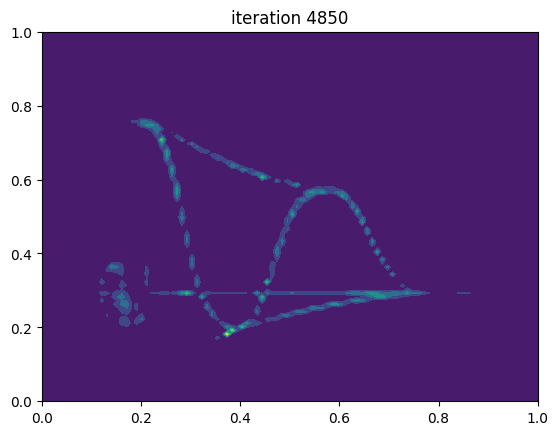

 98%|█████████▊| 4899/5000 [20:41<00:22,  4.50it/s]

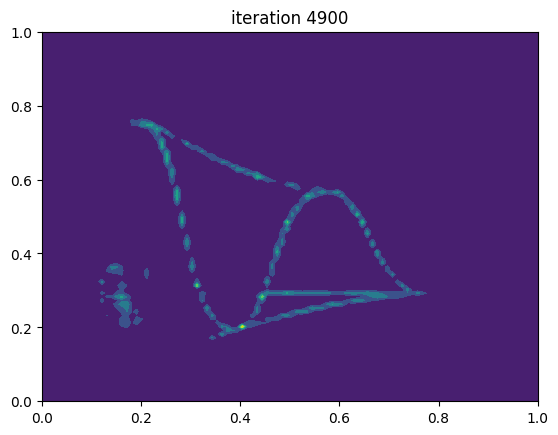

 99%|█████████▉| 4949/5000 [20:54<00:11,  4.50it/s]

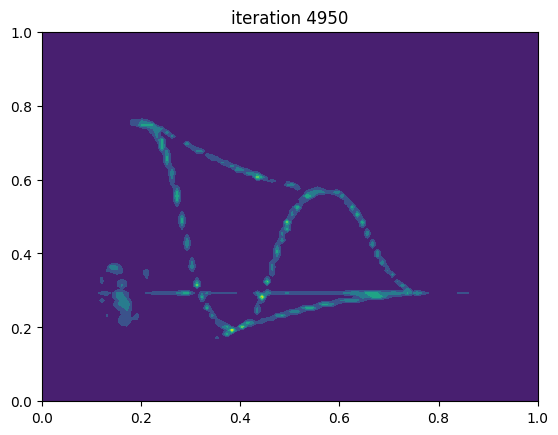

100%|█████████▉| 4999/5000 [21:07<00:00,  4.43it/s]

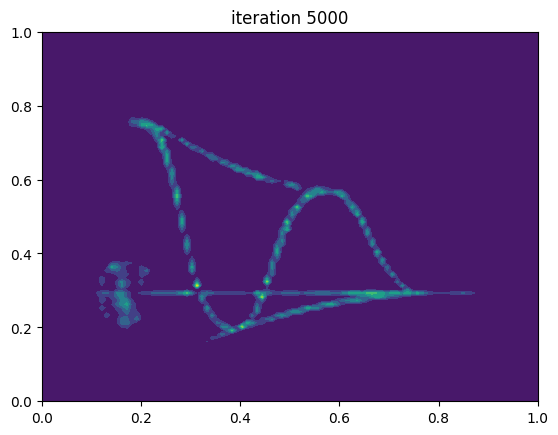

100%|██████████| 5000/5000 [21:08<00:00,  3.94it/s]


In [27]:
num_epochs = 5000

for i in tqdm(range(num_epochs)):
    #x = sample_from_image(img_path, 3000) # geramos os dados
    x = pts
    x = torch.tensor(x, dtype=torch.float32) # transformamos em tensor do torch
    optimizer.zero_grad() # zeramos os gradientes do otimizador
    loss = -flow.log_prob(inputs=x).mean() # definimos a função loss como o inverso do log_prob médio calculado sobre a distribuição
    loss.backward() # calcula os gradientes
    optimizer.step() # atualiza os pesos

    if (i+1) % 50 == 0: # a cada 500 épocas, fazemos um plot
        xline = torch.linspace(0, 1, 100)
        yline = torch.linspace(0, 1, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        #plt.show()
        #plt.close()
        plt.show()

(300, 500, 4)


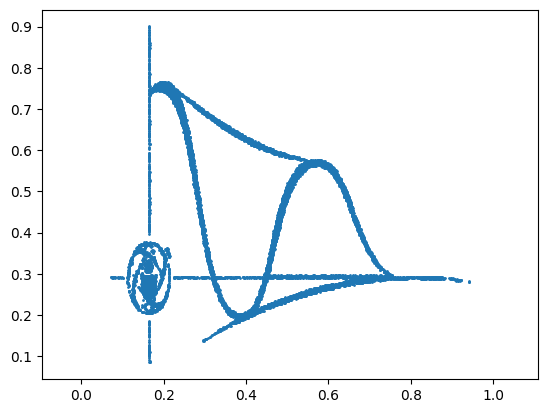

  1%|          | 49/5000 [01:24<2:14:26,  1.63s/it]

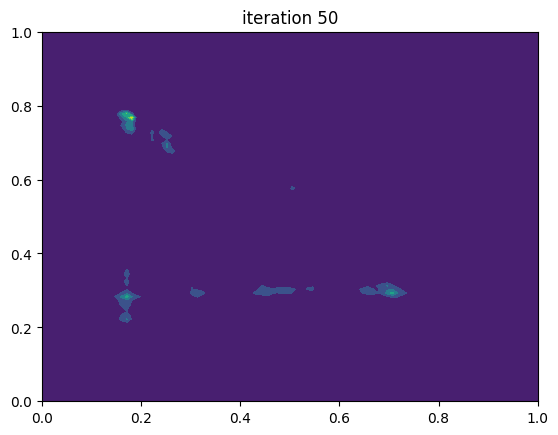

  2%|▏         | 99/5000 [02:51<2:14:12,  1.64s/it]

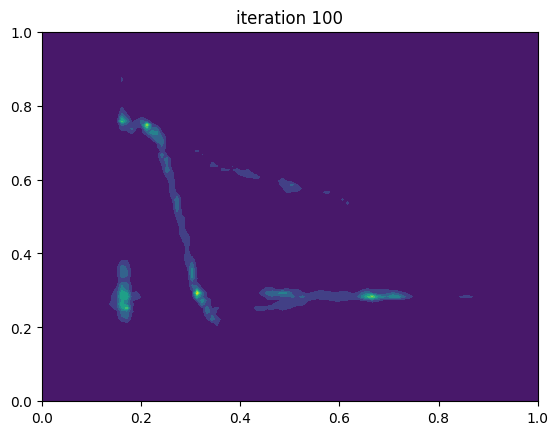

  3%|▎         | 149/5000 [04:17<2:13:40,  1.65s/it]

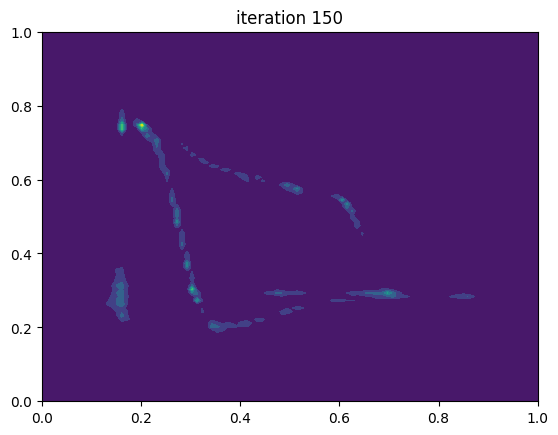

  4%|▍         | 199/5000 [05:43<2:14:47,  1.68s/it]

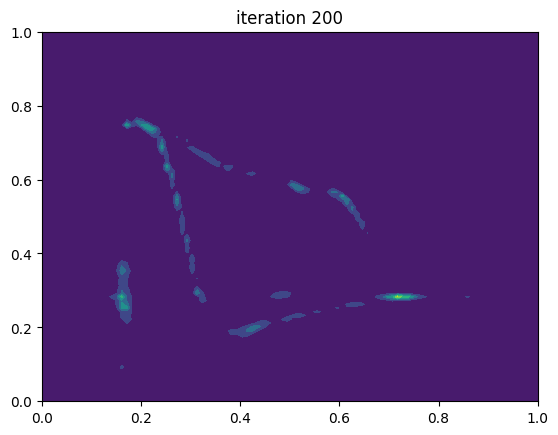

  5%|▍         | 249/5000 [07:09<2:16:54,  1.73s/it]

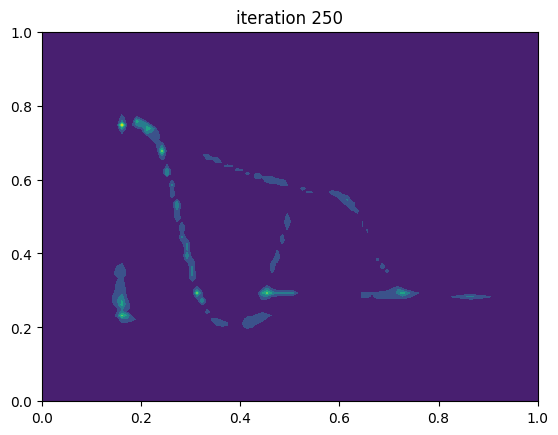

  6%|▌         | 299/5000 [08:35<2:19:38,  1.78s/it]

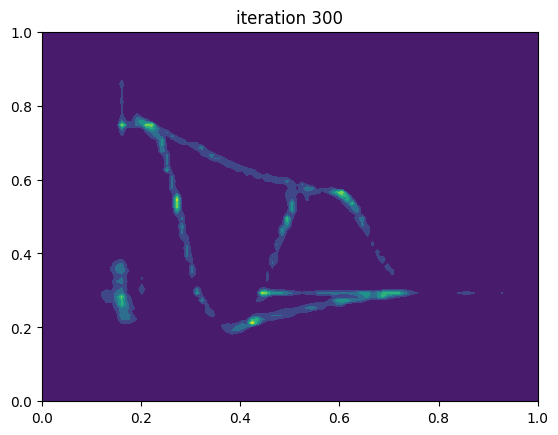

  7%|▋         | 349/5000 [10:01<2:26:27,  1.89s/it]

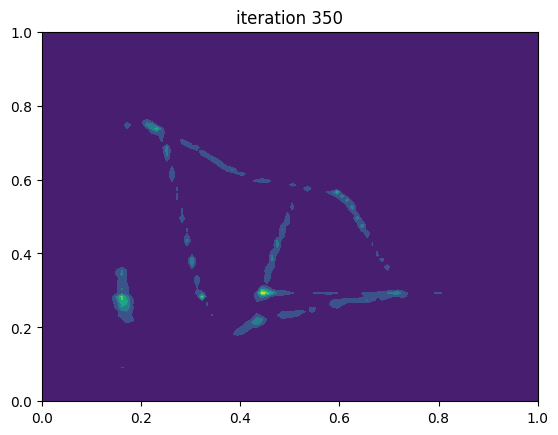

  8%|▊         | 399/5000 [11:27<2:19:22,  1.82s/it]

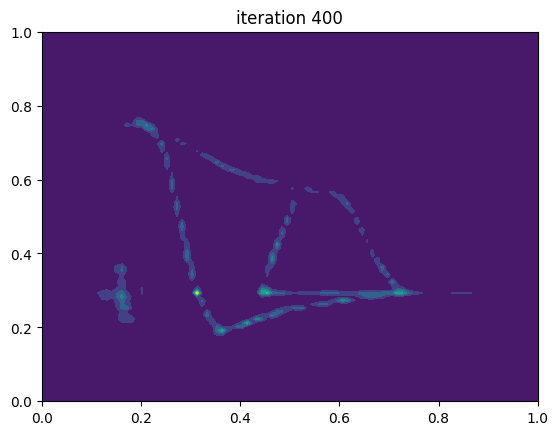

  9%|▉         | 449/5000 [12:52<2:05:09,  1.65s/it]

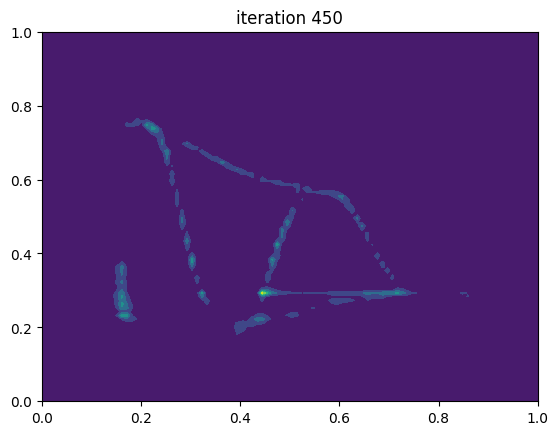

 10%|▉         | 499/5000 [14:18<1:57:48,  1.57s/it]

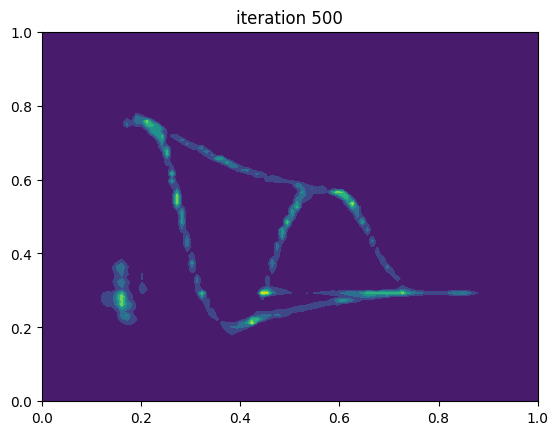

 11%|█         | 549/5000 [15:43<1:57:16,  1.58s/it]

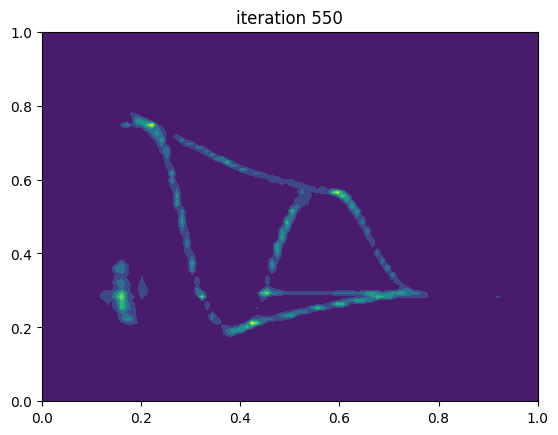

 12%|█▏        | 599/5000 [17:09<1:57:46,  1.61s/it]

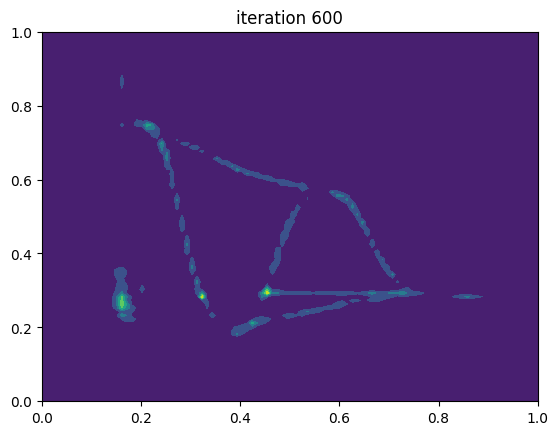

 13%|█▎        | 649/5000 [18:35<1:59:59,  1.65s/it]

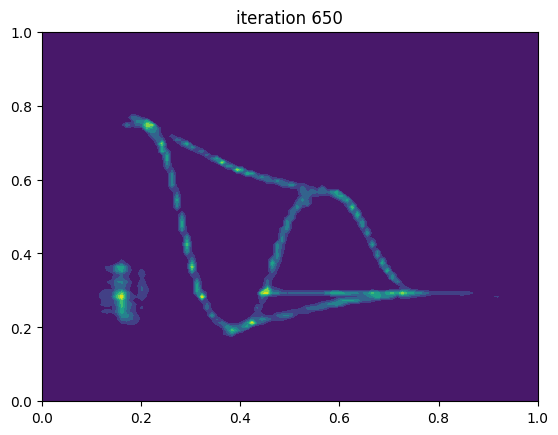

 13%|█▎        | 669/5000 [19:13<2:04:24,  1.72s/it]


KeyboardInterrupt: ignored

In [31]:
base_dist = StandardNormal(shape=[2])
num_layers = 10
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features=2, hidden_features=128)) # hidden_features é o a quantidade de unidades escondidas na rede neural
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/letras_cbpf.png"
#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/Logo_CBPF_Sigla.png"
#img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/49055715328_092031af74_o.png"
img_path = "/content/drive/MyDrive/Mestrado/Eventos/ESCOLA CBPF 2023/Normalizing Flows/imagens/cartaz-da-escola-2019-500x300.png"

im = Image.open(img_path)
arr = np.array(im) # transforma imagem em array

max2 = np.max(arr, axis=2) # refaz a imagem em úma única banda pegando o maior valor dentre as 4

print(arr.shape)

pts = []
w, h = max2.shape
while len(pts) < 10000:
    pt = np.random.rand(2).astype('f') # gera par de números entre 0 e 1 (coordenadas)
    x = int((1 - pt[1]) * w) # multiplica valor pela largura e altura (desnormaliza a coordenada)
    y = int((pt[0]) * h)
    if max2[x,y] > 200: # caso o ponto sorteado não seja branco na imagem de uma banda:
        #print(len(pts)/1e5)
        pts.append(pt) # salva o ponto, repete até ter 10 mil pontos

pts = np.array(pts) # transforma em array

#pts -= np.mean(pts, axis=0)
#pts *= 5
#pts.shape

plt.scatter(pts[:,0], pts[:,1], s=1)
plt.axis('equal')
plt.show()

num_epochs = 5000

for i in tqdm(range(num_epochs)):
    #x = sample_from_image(img_path, 3000) # geramos os dados
    x = pts
    x = torch.tensor(x, dtype=torch.float32) # transformamos em tensor do torch
    optimizer.zero_grad() # zeramos os gradientes do otimizador
    loss = -flow.log_prob(inputs=x).mean() # definimos a função loss como o inverso do log_prob médio calculado sobre a distribuição
    loss.backward() # calcula os gradientes
    optimizer.step() # atualiza os pesos

    if (i+1) % 50 == 0: # a cada 500 épocas, fazemos um plot
        xline = torch.linspace(0, 1, 100)
        yline = torch.linspace(0, 1, 100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        #plt.show()
        #plt.close()
        plt.show()

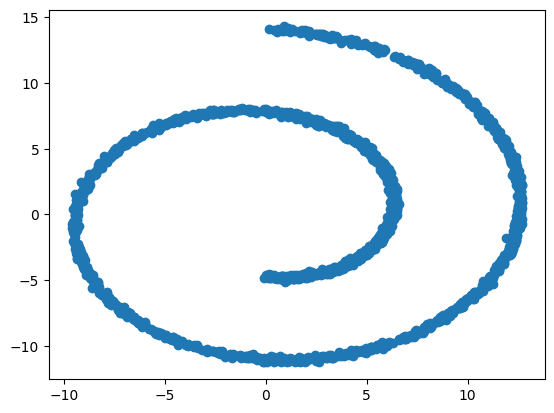

In [41]:
x, t = datasets.make_swiss_roll(2048, noise=0.1, hole=True)



plt.scatter(x[:,0], x[:,2])